In [1]:
import pandas as pd
import gensim
import string
import numpy as np
import glob
import os
from bs4 import BeautifulSoup
from zipfile import ZipFile
import csv
import xml.etree.ElementTree as ET
from pathlib import Path, PureWindowsPath
import csv
from nltk.corpus import stopwords
from tika import parser
from nltk.stem import PorterStemmer
import re
import sklearn as sk
from sklearn.linear_model import LogisticRegression, PoissonRegressor, RidgeClassifier
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, PolynomialFeatures
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import classification_report, auc
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import pickle
from collections import defaultdict
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer
from nltk.tokenize import RegexpTokenizer, word_tokenize
from gensim.sklearn_api import D2VTransformer, W2VTransformer, LdaTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbPipe
from sklearn.feature_extraction import DictVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
import PyPDF2
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_predict, cross_val_score
from statsmodels.api import OLS 

C:\Users\Public\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
def conv_pdf(pdf):
    fileObject = open(pdf, 'rb')
    pdf_reader = PyPDF2.PdfFileReader(fileObject)
    pages = pdf_reader.getNumPages()
    text = []
    for n in list(range(pages)):
        page_text = pdf_reader.getPage(n)
        text.append(page_text.extractText())
    text = ' '.join(text)
    return text

# Problem Statement

Clinical Trials Exploration

Company A is dedicated to bringing down the cost and improving the outcomes of the drug discovery pipeline. As such we are very interested in understanding the drivers behind successful and unsuccessful clinical trials.



### Phase 1:

https://www.clinicaltrials.gov/
Contains all 270k clinical trials performed in the US.  Each of these clinical trials will have papers associated with it.  Grab the clinical trials and the associated papers and store them in a way that links the two.  You may need to figure out how to grab the associated papers (they will not be stored in the same repository, and you may need to grab them using a different REST API).


### Phase 2:
Once we have the data all downloaded and linked, we’ll want to start looking for features that may drive whether or not the clinical trial was a success or a failure.  This will mean combing through the trial itself for “features” that we can use (e.g. number of citations on the associated papers, which drugs were under study, phase of the trial, etc . . .).

Some pointers:
Start by understanding the clinical trials themselves.  Google what you can, and if you still have specific questions around what particular things mean I can get those questions answered by people we have over here.  It will be very important that you understand what the fields in the trial mean in order to make good decisions on what features might make a difference.

I’m most interested in doing some deep text-based analysis on the papers associated with the trials themselves.  Try to set things up so that this analysis will be easy.  We’ll want to ask questions like “for all the successful trials, let’s run this algorithm against the associated papers”.  We’ll provide the algorithm (or some pointers to where you can download it).  



## Data Collection

There are two ways to go about retrieving the clinical trials: download all clinical trails in a .zip file from clinicaltrials.gov or you can use their api. We will download the zip folder containing all the clinical trials.

Clinical trials point to scientific research papers because the papers indicate that a drug works in some capacity in vivo for example. We will need to collect all of the research papers associated with each clinical trial. Downloading the research papers requires parsing the PMIDs from the clinical trials, creating a list, and downloading it using : https://github.com/billgreenwald/Pubmed-Batch-Download

In [6]:
# assign root directory
rootdir = './NCT_files/'

# make a list of all the nct_files in the directory
nct_files = []
for subddir, dirs, files in os.walk(rootdir):
    for file in files:
        nct_files.append(os.path.join(subddir,file).replace('\\', '/'))


In [ ]:
#view an nct file
nct_files[1]


In [16]:
#
all_xmls = []
zipfile = './AllPublicXML.zip'
with ZipFile(zipfile, 'r') as myzip:
    all_xmls.append(zip.namelist())
    

In [346]:
def split_list(alist, wanted_parts=1):
    length = len(alist)
    return [ alist[i*length // wanted_parts: (i+1)*length // wanted_parts] 
             for i in range(wanted_parts) ]

# split list into 30 parts
PMIDs_split = split_list(PMIDs,30)

# create 30 .csv files with a list of PMIDs
for i, pmid in enumerate(PMIDs_split):
    pd.DataFrame(pmid).to_csv('./list_of_PMIDs'+str(i)+'.csv', index = False)



## Pre-processing

DataFrame construction:
1. Download the dataset from clinicaltrials.gov
2. Examine the XML files to determine what elements I would like to extract
3. Go through every XML file for the specified elements in child_list and gchild_list. Elements are shown in the dataframe above.
4. Determine what part of the dataset is relevant in making a prediction. Studies selected to go further with the analysis included completed, terminated, and suspended studies. This is because we at least have the outcome of these studies. We also want studies that have a phase shown.
5. Fill in missing values. 


Now we want to preprocess the text. These texts would be in the columsn 'intervention_name', 'intervention_type', '

In [384]:
child_list = ['brief_title', 'source', 'overall_status', 'study_type','has_expanded_access','condition',
                'study_first_posted', 'verification_date', 'last_update_posted', 'keyword', 'phase',
              'enrollment', 'intervention_browse', 'PMID']
gchild_list = ['textblock', 'nct_id','observational_model', 'time_perspective', 'intervention_type',
               'is_fda_regulated_drug', 'is_fda_regulated_device', 
               'defined Population', 'intervention_type', 'intervention_name', 
               'gender', 'minimum_age', 'maximum_age','healthy_volunteers', 'country',
               'mesh_term', 'allocation', 'intervention_model', 'primary_purpose', 'masking','PMID']

def parse_files(nct):
    dataframes = []
    for f in nct:
            dataframes.append(parse_xml(f))
    df = pd.concat(dataframes)
    return df
      
  

def parse_xml(xml):
        #create empty lists for the tag and text
        first_layer_tag = []
        first_layer_text = []
        
        tree = etree.parse(xml)
        root = tree.getroot()
        
        for child in root.iter([child_list]):
            first_layer_tag.append(child.tag)
            first_layer_text.append(child.text)
        for gchild in root.iter([gchild_list]):
            first_layer_tag.append(gchild.tag)
            first_layer_text.append(gchild.text)
        df = pd.DataFrame(data = [first_layer_text],
                          columns = first_layer_tag
                          )
        df = df.loc[:,~df.columns.duplicated()]
        return df
    
#dataframe = parse_files(nct_files)
            

In [7]:
child_list = ['brief_title', 'source', 'overall_status', 'study_type','has_expanded_access','condition',
                'study_first_posted', 'verification_date', 'last_update_posted', 'keyword', 'phase',
              'enrollment', 'intervention_browse', 'PMID']
gchild_list = ['textblock', 'nct_id','observational_model', 'time_perspective', 'intervention_type',
               'is_fda_regulated_drug', 'is_fda_regulated_device', 
               'defined Population', 'intervention_type', 'intervention_name', 
               'gender', 'minimum_age', 'maximum_age','healthy_volunteers', 'country',
               'mesh_term', 'allocation', 'intervention_model', 'primary_purpose', 'masking']



np_child_list = np.array(['brief_title', 'source', 'overall_status', 'study_type','has_expanded_access','condition',
                'study_first_posted', 'verification_date', 'last_update_posted', 'keyword', 'phase',
              'enrollment', 'intervention_browse', 'PMID'])
np_gchild_list = np.array(['textblock', 'nct_id','observational_model', 'time_perspective', 'intervention_type',
               'is_fda_regulated_drug', 'is_fda_regulated_device', 
               'defined Population', 'intervention_type', 'intervention_name', 
               'gender', 'minimum_age', 'maximum_age','healthy_volunteers', 'country',
               'mesh_term', 'allocation', 'intervention_model', 'primary_purpose', 'masking'])


def parse_files(nct):
    dataframes = []
    for f in nct:
            dataframes.append(parse_xml(f))
    df = pd.concat(dataframes)
    return df



def parse_xml(xml):
        #create empty lists for the tag and text
    first_layer_tag = []
    first_layer_text = []
        
    tree = etree.parse(xml)
    root = tree.getroot()
        
    for child in root.iter([np_child_list]+[np_gchild_list]):
        first_layer_tag.append(child.tag)
        first_layer_text.append(child.text)
        
   # for gchild in root.iter([np_gchild_list]):
    #    first_layer_tag.append(gchild.tag)
     #   first_layer_text.append(gchild.text)
    df = pd.DataFrame(data = np.array([first_layer_text]),
                      columns = first_layer_tag)
    if 'PMID' in df.columns: 
        pmids_df = df.loc[:, ['PMID']]
        transpose_df = pmids_df.transpose()
        np_pmids = transpose_df.to_numpy()
        flattened = list(np_pmids.reshape(1,len(np_pmids)).flatten())
        pmids = ', '.join(flattened)
        df['PMIDs'] = pmids
        
    
    #df = df.loc[:,~df.columns.duplicated()]
    return df
#parse

In [60]:
dataframe = parse_files(nct_files)

C:\Users\Public\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """


In [4]:
def repeat_columns(col):
    if col in df.columns:
        col_df = df.loc[:, [col]]
        transpose_df = col_df.transpose()
        np_col = transpose_df.to_numpy()
        flattened = list(np_col.reshape(1,len(np_col)).flatten())
        cols = ', '.join(flattened)
        return cols
    else:
        None

Now we must work to retrieve the PMIDs. First we find the PMIDS that we need from the DataFrame, then we split them into several .csv files. After we run several python programs in parallel to download the PMIDs.

In [2]:
import PyPDF2
def isFullPdf(f):
    end_content = ''
    start_content = ''
    size = os.path.getsize(f)
    if size < 1024: return False 
    with open(f, 'rb') as fin: 
        #start content 
        fin.seek(0, 0)
        start_content = fin.read(1024)
        start_content = start_content.decode("ascii", 'ignore' )
        fin.seek(-1024, 2)
        end_content = fin.read()
        end_content = end_content.decode("ascii", 'ignore' )
    start_flag = False
    #%PDF
    if start_content.count('%PDF') > 0:
        start_flag = True
    
        
    if end_content.count('%%EOF') and start_flag > 0:
        return True
    eof = bytes([0])
    eof = eof.decode("ascii")
    if end_content.endswith(eof) and start_flag:
        return True
    return False



In [3]:
dirs = os.listdir('./tokens')
def pmid_text(pmids):
    pmid_t = []
    for pmid in pmids:
        if pmid+'.txt' in dirs:
            with open('./fetched_pdfs/'
                      +pmid+'.txt', 'rb') as file:
                pmid_t.append(pickle.load(file))
    else:
        next
    return pmid_t 

In [554]:
PMIDs = []
#drop na values and convert series to numpy array
PMIDs_to_scrape = df['PMIDs'].dropna().to_numpy()

#remove comma from each value
PMIDs_to_scrape = [l.replace(",", "") for l in PMIDs_to_scrape]

#split pmids 
PMIDs_to_scrape = [l.split(' ')for l in PMIDs_to_scrape]


for pmids in PMIDs_to_scrape:
    for pmid in pmids:
        PMIDs.append(pmid)

#capture unique PMIDs      
PMIDs = set(PMIDs)
PMIDS = list(PMIDs)

In [189]:
pdfs = os.listdir('./fetched_pdfs/')
pdfs = ['./fetched_pdfs/'+pdf for pdf in pdfs]

Drop columns related to observational studies and other variables we will not need for analysis. 

In [11]:
df.drop(labels = ['observational_model', 'intervention_browse',
                    'time_perspective', 'keyword', 'defined Population', 'mesh_term'],
          axis = 1, inplace = True)

In [13]:
#combine the dataset where the overall_status is 'completed terminated or suspended'
df = pd.concat((completed, terminated, suspended))

Load the dataset.

In [67]:
org_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354534 entries, 0 to 0
Data columns (total 33 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   brief_title              354534 non-null  object 
 1   source                   354534 non-null  object 
 2   overall_status           354534 non-null  object 
 3   study_type               354534 non-null  object 
 4   has_expanded_access      348493 non-null  object 
 5   condition                353674 non-null  object 
 6   study_first_posted       354534 non-null  object 
 7   verification_date        353692 non-null  object 
 8   last_update_posted       354534 non-null  object 
 9   keyword                  231168 non-null  object 
 10  phase                    277467 non-null  object 
 11  enrollment               347826 non-null  object 
 12  intervention_browse      125840 non-null  object 
 13  PMID                     354534 non-null  object 
 14  textblock

In [2]:
with open('./../../../Desktop/df.pkl', 'rb') as file:
    org_df = pickle.load(file)

These 4 columns have multiple data points. We will exclude them from the extractions for now.

In [3]:
l = ['intervention_type', 'intervention_name', 'textblock' ,'PMID', 'PMID_tokens']

for col in org_df.columns:
    if col not in l:
        org_df[col] = org_df.loc[:,col].str[0]

Next we want to drop columns that we will not use for analysis. Let's also select the specific study type we want to analyze. 

There are two different study types: interventional and observational.
Clinical trials are interventional studies hence we will divide our dataset and look at only interventional studies.

In [4]:
def num_of_papers(pmids):
    pmid = pmids.split(' ')
    return len(pmid)

org_df['num_of_papers'] = org_df['PMID'].map(num_of_papers)

In [5]:
#drop columns
org_df.drop(['observational_model', 'time_perspective', 'verification_date',
             'defined Population', 'intervention_browse',
             'brief_title', 'keyword', 'mesh_term', 'PMID_tok', 'enrollment'], axis = 1, inplace = True)
#org_df['success'] = org_df['phase'] == 'Phase 4'

#interventional studies only
org_df = org_df[org_df.loc[:,'study_type'] == 'Interventional']

#replace N/A values in 'phase' as np.nan
org_df.loc[:, 'phase'].replace('N/A', np.nan, inplace = True)

#drop the na values in 'phase'
org_df.dropna(subset = ['phase'],inplace = True)

#set the index
org_df.set_index('nct_id', inplace = True)

#capture completed, terminated, withdrawn values in overall_status
completed = org_df[org_df.loc[:, 'overall_status'] == 'Completed']
terminated = org_df[org_df.loc[:, 'overall_status'] == 'Terminated']
withdrawn = org_df[org_df.loc[:, 'overall_status'] == 'Withdrawn']

# combine the 3 dataframes
org_df = pd.concat([completed, terminated, withdrawn])

# add a new column
org_df['num_of_papers'] = org_df['PMID'].map(num_of_papers)

# create a success column 
org_df.loc[:, 'success'] = (org_df.loc[:,'overall_status'] == 'Completed') & (org_df.loc[:, 'phase'] == 'Phase 4')


In [12]:
org_df

,source,overall_status,study_type,has_expanded_access,condition,study_first_posted,last_update_posted,phase,enrollment,PMID,...,minimum_age,maximum_age,healthy_volunteers,country,allocation,intervention_model,primary_purpose,masking,PMID_tokens,num_of_papers
nct_id,,,,,,,,,,,,,,,,,,,,,
NCT00000113,Stony Brook University,Completed,Interventional,No,Myopia,"September 24, 1999","April 15, 2016",Phase 3,469,12657584 15223788 16009841,...,6 Years,12 Years,No,United States,Randomized,Parallel Assignment,Treatment,"Triple (Participant, Investigator, Outcomes As...","Accommodation, and, Related, Risk, Factors, As...",3
NCT00000125,Washington University School of Medicine,Completed,Interventional,No,Ocular Hypertension,"September 24, 1999","June 2, 2020",Phase 3,1636,10326953 10980763 11024416 11581049 11755836 1...,...,40 Years,80 Years,No,NaN,Randomized,Parallel Assignment,Prevention,None (Open Label),"Asymmetries, and, Visual, Field, Summaries, as...",63
NCT00000129,National Eye Institute (NEI),Completed,Interventional,No,Myopia,"September 24, 1999","September 17, 2009",Phase 3,NaN,6338438 6380467 6638126 6486212 3872431 388512...,...,21 Years,N/A,No,NaN,Randomized,NaN,Treatment,NaN,"British, Journal, of, Ophthalmology, ,, 1988, ...",32
NCT00000136,Johns Hopkins Bloomberg School of Public Health,Completed,Interventional,No,HIV Infections,"September 24, 1999","October 22, 2015",Phase 3,234,1315661 8660161 8660169 8660168 9207349 926253...,...,13 Years,N/A,No,NaN,Randomized,Parallel Assignment,Treatment,Single (Outcomes Assessor),"Mortality, in, Patients, with, the, Acquired, ...",13
NCT00000139,National Eye Institute (NEI),Completed,Interventional,No,"Keratitis, Herpetic","September 24, 1999","March 24, 2010",Phase 3,NaN,8540857 9194719 9696640,...,18 Years,N/A,No,United States,Randomized,NaN,Treatment,NaN,"Acyclovir, for, the, Prevention, of, Recurrent...",3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NCT04242966,Clinical Evaluation Research Unit at Kingston ...,Withdrawn,Interventional,No,Critical Illness,"January 27, 2020","June 18, 2020",Phase 3,0,22811443 21705881 28388372 25781411 23991656 2...,...,18 Years,N/A,No,NaN,Randomized,Parallel Assignment,Basic Science,None (Open Label),"Thrombus, Aspiration, during, ST-Segment, Elev...",70
NCT04287543,Instituto Mexicano del Seguro Social,Withdrawn,Interventional,No,Parkinson Disease,"February 27, 2020","August 4, 2020",Phase 2/Phase 3,0,28332488 12657434 20460187 24235893 24687146 1...,...,20 Years,N/A,No,Mexico,Randomized,Parallel Assignment,Treatment,"Double (Participant, Investigator)","Sublethal, RNA, Oxidation, as, a, Mechanism, f...",40
NCT04290858,Xijing Hospital,Withdrawn,Interventional,No,Coronavirus Infections,"March 2, 2020","March 24, 2020",Phase 2,0,15546092 15234326 31978945 32031570 32085846,...,18 Years,N/A,No,NaN,Randomized,Parallel Assignment,Treatment,None (Open Label),"A, Novel, Coronavirus, from, Patients, with, P...",5


## Data Exploration

Let's begin by splitting the dataset into it's training and testing set. We will also define the target variable. There are other columns that also need to be dropped.

In [6]:
X = org_df.drop(['success', 'phase', 'PMID', 'overall_status',
             'study_first_posted', 'last_update_posted', 'study_type'], axis = 1)
y = org_df['success']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, shuffle = True, random_state = 26)

All columns are considered objects. This needs to be addressed. We can infer from the column names what each column may contain. We can also look at the distribution of values in each column.

In [8]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3614 entries, NCT01720316 to NCT01428843
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   source                   3614 non-null   object
 1   has_expanded_access      3553 non-null   object
 2   condition                3614 non-null   object
 3   textblock                3614 non-null   object
 4   intervention_type        3614 non-null   object
 5   is_fda_regulated_drug    561 non-null    object
 6   is_fda_regulated_device  554 non-null    object
 7   intervention_name        3614 non-null   object
 8   gender                   3614 non-null   object
 9   minimum_age              3614 non-null   object
 10  maximum_age              3614 non-null   object
 11  healthy_volunteers       3606 non-null   object
 12  country                  3415 non-null   object
 13  allocation               3439 non-null   object
 14  intervention_model       339

In [20]:
X_train.head()

,source,has_expanded_access,condition,enrollment,textblock,intervention_type,is_fda_regulated_drug,is_fda_regulated_device,intervention_name,gender,minimum_age,maximum_age,healthy_volunteers,country,allocation,intervention_model,primary_purpose,masking,PMID_tokens,num_of_papers
nct_id,,,,,,,,,,,,,,,,,,,,
NCT01720316,Mclean Hospital,No,Schizo-affective Disorder,2,[\n The purpose of this study is to asses...,"[Drug, Drug]",Yes,No,"[Glycine, placebo]",All,18,65,No,United States,Randomized,Crossover Assignment,Treatment,"Quadruple (Participant, Care Provider, Investi...","Untitled, Document, 1822, Am, J, Psychiatry, 1...",33
NCT00297258,GlaxoSmithKline,No,"Sarcoma, Soft Tissue",148,[\n The purpose of this study is to evalu...,[Drug],NaN,NaN,[pazopanib],All,21,0,No,Belgium,Non-Randomized,Single Group Assignment,Treatment,None (Open Label),"Cytokine, and, angiogenic, factors, associated...",2
NCT01384149,Meir Medical Center,No,Primary Open Angle Glaucoma,32,[\n The purpose of this study is to evalu...,"[Device, Device]",NaN,NaN,"[external slt, standard slt]",All,40,0,No,Israel,Randomized,Parallel Assignment,Treatment,None (Open Label),"Early, Diagnosis, of, Ocular, Hypertension, Us...",11
NCT01267682,Penn State University,No,Delirium,283,[\n The purpose of this study is to test ...,[Behavioral],NaN,NaN,[Cognitive Stimulation],All,65,0,No,United States,Randomized,Parallel Assignment,Treatment,Single (Outcomes Assessor),"STUDY, PROTOCOL, Open, Access, Study, protocol...",11
NCT00331799,Duke University,No,Major Depressive Disorder,18,[\n The purpose of this study is to explo...,[Drug],NaN,NaN,[Duloxetine],All,18,65,No,United States,N/A,Single Group Assignment,Treatment,None (Open Label),"Article, 1702, Am, J, Psychiatry, 159:10, ,, O...",6


There are several missing values to deal with. Most columns are listed as object which seems incorrect. We will deal with this so we can explore the data more clearly.

In [8]:
def change_age(ages):
    lis = []
    n = str(ages).split(' ')
    if len(n) < 2:
        return 0   
    elif n[1] == 'Months' or n[1] == 'Month':
        return (1/12) * int(n[0])   
    elif n[1] == 'Years' or n[1] == 'Year':
        return n[0]
    elif n[1] == 'Days' or n[1] == 'Day':
        return (1/365) * int(n[0])
    elif n[1] == 'Weeks' or n[1] == 'Week':
        return (1/52) * int(n[0])
    elif n[1] == 'Hours' or n[1] == 'Hour':
        return (1/8760) * int(n[0])
    elif n[1] == 'Minutes' or n[1] == 'Minute':
        return(1/525600) * int(n[0])

In [9]:
#correctly label columns as a category
X_train.loc[:, 'intervention_model'] = X_train.loc[:,'intervention_model'].astype('category')
X_train.loc[:, 'healthy_volunteers'] = X_train.loc[:, 'healthy_volunteers'].astype('category')
X_train.loc[:, 'masking'] = X_train.loc[:, 'masking'].astype('category')
X_train.loc[:, 'primary_purpose'] = X_train.loc[:, 'primary_purpose'].astype('category')
X_train.loc[:, 'allocation'] = X_train.loc[:, 'allocation'].astype('category')
X_train.loc[:, 'gender'] = X_train.loc[:, 'gender'].astype('category')
X_train.loc[:, 'is_fda_regulated_drug'] = X_train.loc[:, 'is_fda_regulated_drug'].astype('category')
X_train.loc[:, 'is_fda_regulated_device'] = X_train.loc[:, 'is_fda_regulated_device'].astype('category')
X_train.loc[:, 'has_expanded_access'] = X_train.loc[:, 'has_expanded_access'].astype('category')
X_train.loc[:,'country'] = X_train.loc[:, 'country'].astype('category')
#enrollment_mean = X_train[X_train.loc[:, 'enrollment'].notnull()].loc[:, 'enrollment'].astype(int).median()
#X_train.loc[:, 'enrollment'].fillna(enrollment_mean, inplace = True)

#correctly label columns as int
X_train.loc[:,'minimum_age'] = X_train.loc[:, 'minimum_age'].map(change_age)
X_train.loc[:, 'maximum_age'] = X_train.loc[:, 'maximum_age'].map(change_age)
X_train.loc[:, 'maximum_age'] = X_train.loc[:, 'maximum_age'].astype(int)
X_train.loc[:, 'minimum_age'] = X_train.loc[:, 'minimum_age'].astype(int)

C:\Users\Public\Anaconda3\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


We've converted the columns into their necessary datatypes. The clinical trials website illustrates the datatype that is used for each column. Next we should take deeper look at each column to better understand the distribution of the columns and to see the necessary steps to take when filling in missing values.

In [22]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3614 entries, NCT01720316 to NCT01428843
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   source                   3614 non-null   object  
 1   has_expanded_access      3553 non-null   category
 2   condition                3614 non-null   object  
 3   enrollment               3614 non-null   int32   
 4   textblock                3614 non-null   object  
 5   intervention_type        3614 non-null   object  
 6   is_fda_regulated_drug    561 non-null    category
 7   is_fda_regulated_device  554 non-null    category
 8   intervention_name        3614 non-null   object  
 9   gender                   3614 non-null   category
 10  minimum_age              3614 non-null   int32   
 11  maximum_age              3614 non-null   int32   
 12  healthy_volunteers       3606 non-null   category
 13  country                  3415 non-null   category
 

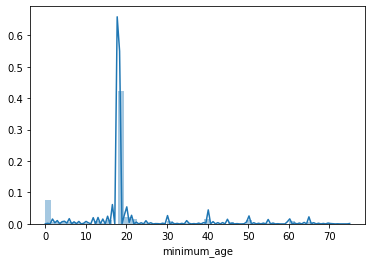

In [112]:
sns.distplot(X_train['minimum_age'])

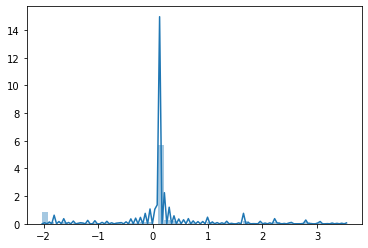

In [121]:
min_age = power_transform(X_train['minimum_age'])
sns.distplot(min_age)

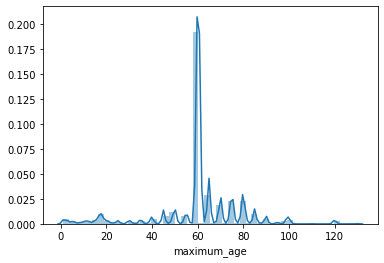

In [124]:
sns.distplot(X_train['maximum_age'])

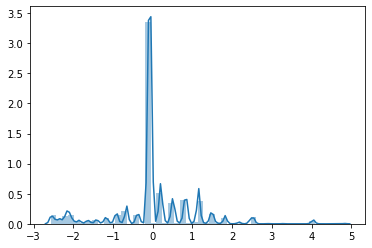

In [126]:
max_age = power_transform(X_train['maximum_age'])
sns.distplot(max_age)

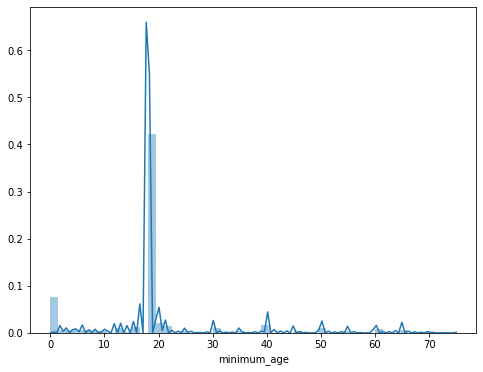

In [91]:
plt.figure(figsize=(8,6))
sns.distplot(X_train['minimum_age'])

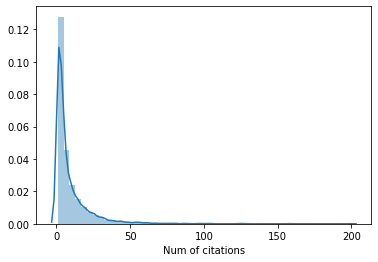

In [129]:
sns.distplot(X_train['Num_of_papers'])

In [194]:
X_train.select_dtypes('number').describe()

,minimum_age,maximum_age,num_of_papers
count,3614.000000,3614.000000,3614.000000
mean,18.254012,32.063641,9.190371
std,11.902417,35.218536,13.323635
min,0.000000,0.000000,1.000000
25%,18.000000,0.000000,2.000000
50%,18.000000,14.000000,4.000000
75%,18.000000,65.000000,11.000000
max,75.000000,130.000000,199.000000


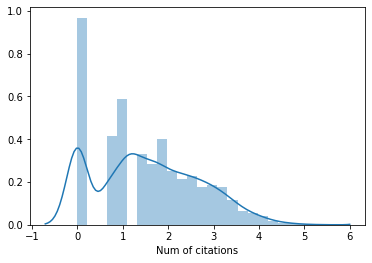

In [137]:
sns.distplot(np.log(X_train['num_of_papers']))

In [144]:
from sklearn.preprocessing import QuantileTransformer
def power_transform(column):
    power = PowerTransformer()
    col_trans = column.to_numpy()
    col_trans = col_trans.reshape(len(col_trans), 1)
    col_trans = power.fit_transform(col_trans)
    return col_trans

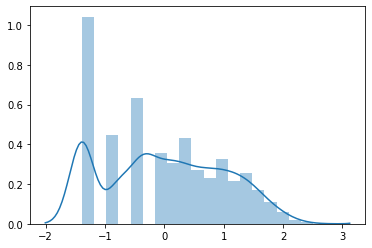

In [145]:
num_citations = power_transform(X_train['Num of citations'])
sns.distplot(num_citations)

In [186]:
X_train['is_fda_regulated_device'].value_counts()

No     542
Yes     12
Name: is_fda_regulated_device, dtype: int64

In [188]:
X_train['is_fda_regulated_drug'].value_counts()

Yes    292
No     269
Name: is_fda_regulated_drug, dtype: int64

In [190]:
X_train['gender'].value_counts()

All       3192
Female     264
Male       158
Name: gender, dtype: int64


In [194]:
X_train['country'].value_counts()

United States         1730
Canada                 139
France                 118
Germany                117
Italy                  103
                      ... 
Estonia                  1
El Salvador              1
Dominican Republic       1
Côte D'Ivoire            1
Albania                  1
Name: country, Length: 103, dtype: int64

In [195]:
X_train['allocation'].value_counts()

Randomized        2427
N/A                593
Non-Randomized     419
Name: allocation, dtype: int64

In [196]:
X_train['intervention_model'].value_counts()

Parallel Assignment        2114
Single Group Assignment     892
Crossover Assignment        279
Factorial Assignment         79
Sequential Assignment        34
Name: intervention_model, dtype: int64

In [197]:
X_train['primary_purpose'].value_counts()

Treatment                          2699
Prevention                          489
Diagnostic                          103
Basic Science                        96
Supportive Care                      76
Other                                53
Health Services Research             24
Screening                            10
Educational/Counseling/Training       1
Name: primary_purpose, dtype: int64

In [198]:
X_train['masking'].value_counts()

None (Open Label)                                                          1712
Quadruple (Participant, Care Provider, Investigator, Outcomes Assessor)     554
Double (Participant, Investigator)                                          290
Triple (Participant, Care Provider, Investigator)                           161
Single (Outcomes Assessor)                                                  134
Double                                                                      123
Single (Participant)                                                        116
Triple (Participant, Investigator, Outcomes Assessor)                       111
Double (Participant, Outcomes Assessor)                                      52
Single (Investigator)                                                        49
Double (Participant, Care Provider)                                          47
Triple (Participant, Care Provider, Outcomes Assessor)                       29
Single                                  

In [734]:
X_train['success'] = y_train

C:\Users\Public\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [737]:
success_df = X_train[X_train['success'] == True]
fail_df = X_train[X_train['success'] == False]

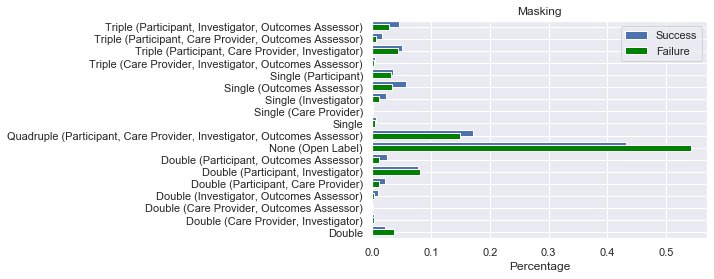

In [844]:
success_df['masking'].value_counts(normalize = True).sort_index().plot( kind = 'barh',position = 0, label = 'Success').legend()
fail_df['masking'].value_counts(normalize = True).sort_index().plot(kind = 'barh', color = 'green', label = 'Failure').legend()
plt.title('Masking')
plt.xlabel('Percentage')
plt.show()

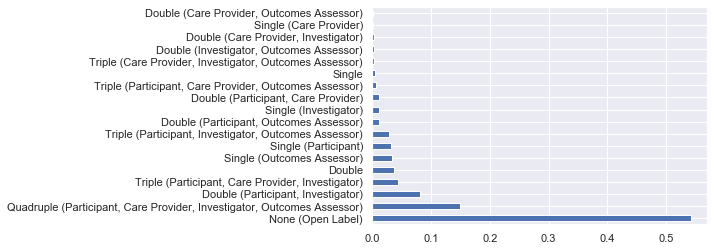

In [753]:
fail_df['masking'].value_counts(normalize = True).plot(kind = 'barh')

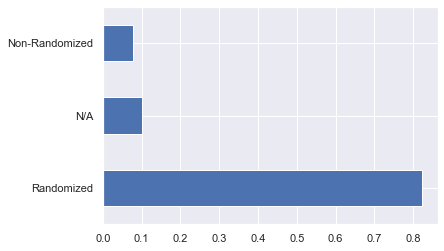

In [752]:
success_df['allocation'].value_counts(normalize = True).plot(kind = 'barh')

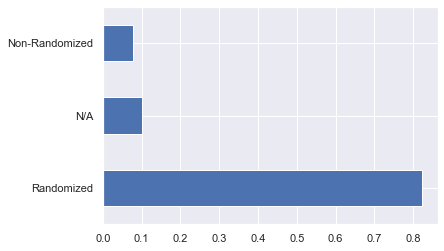

In [755]:
success_df['allocation'].value_counts(normalize = True).plot(kind = 'barh')

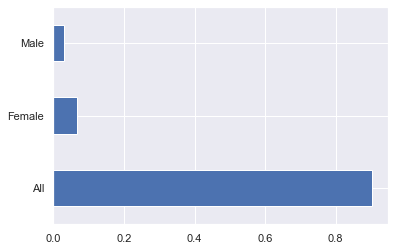

In [759]:
success_df['gender'].value_counts(normalize = True).plot(kind = 'barh')

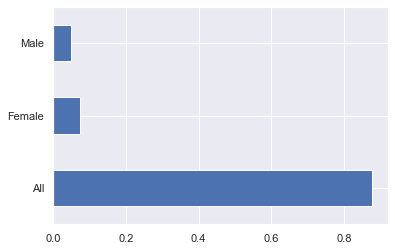

In [760]:
fail_df['gender'].value_counts(normalize =True).plot(kind = 'barh')

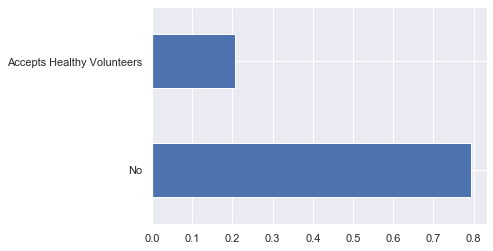

In [763]:
success_df['healthy_volunteers'].value_counts(normalize = True).plot(kind = 'barh')

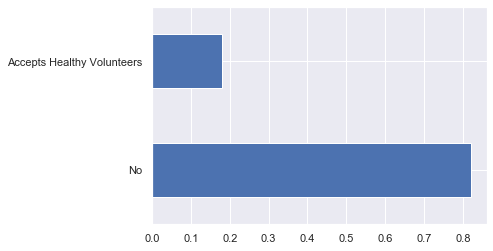

In [765]:
fail_df['healthy_volunteers'].value_counts(normalize = True).plot(kind = 'barh')

In [814]:
suc.to_list()

[0.7102102102102102,
 0.16216216216216217,
 0.10510510510510511,
 0.02252252252252252,
 0.0]

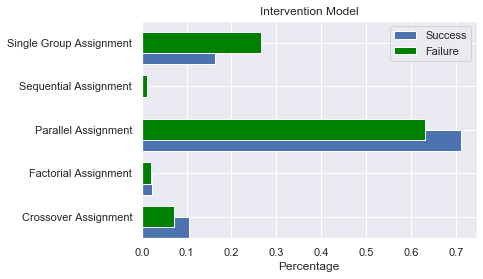

In [845]:
fig, ax = plt.subplots()
suc = success_df['intervention_model'].value_counts(normalize = True).sort_index().plot(kind = 'barh', position = 1, label = 'Success').legend()
fail = fail_df['intervention_model'].value_counts(normalize = True).sort_index().plot(kind = 'barh', color = 'green', label = 'Failure').legend()
plt.title('Intervention Model')
plt.xlabel('Percentage')
plt.show()
#rects1 = ax.plot(kind = 'bar',suc.to_list())
#rects2 = ax.bar( fail, label='Women')
#plt.bar(success_df['intervention_model'].values, int_model_success)

#success_df['intervention_model'].value_counts().

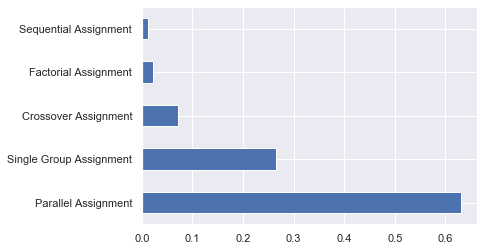

In [770]:
fail_df['intervention_model'].value_counts(normalize = 'True').plot(kind = 'barh')

Take a look at the target variable. The amount of successful trials is under represented. This will effect our precision and recall. We can look to apply methods to synthetically increase the smaller class.

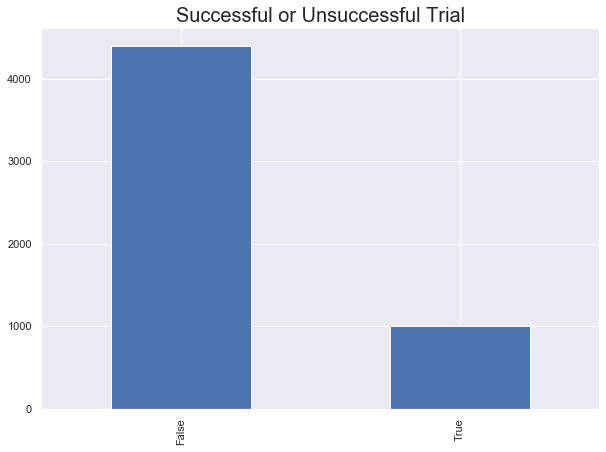

In [85]:
sns.set()

plt.plot(figsize = (10,10))
y.value_counts().plot(kind = 'bar', figsize = (10,7))
plt.title
plt.title('Successful or Unsuccessful Trial', fontsize = 20);

## Data Cleaning

For the categorical variables we will one hot encode them. Categorical variables must be represented in a numerical format. This will also increase the complexity and dimensionality of the dataset.

In [10]:
#df['intervention_model'].fillna(df['intervention_model'].mode())
X_train.loc[:, 'intervention_model'].fillna(X_train['intervention_model'].mode()[0], inplace = True)
X_train.loc[:, 'healthy_volunteers'].fillna(X_train['healthy_volunteers'].mode()[0], inplace = True)
X_train.loc[:, 'masking'].fillna(X_train['masking'].mode()[0], inplace = True)
X_train.loc[:, 'primary_purpose'].fillna(X_train['primary_purpose'].mode()[0], inplace = True)
X_train.loc[:, 'allocation'].fillna(X_train['allocation'].mode()[0], inplace = True)
X_train.loc[:, 'country'].fillna(X_train['country'].mode()[0], inplace = True)
X_train.loc[:, 'gender'].fillna(X_train['gender'].mode()[0], inplace = True)
X_train.loc[:, 'has_expanded_access'].fillna('No', inplace = True)
X_train.loc[:, 'is_fda_regulated_drug'].fillna(X_train['is_fda_regulated_drug'].mode()[0], inplace = True)
X_train.loc[:, 'is_fda_regulated_device'].fillna(X_train['is_fda_regulated_device'].mode()[0], inplace = True)

C:\Users\Public\Anaconda3\lib\site-packages\pandas\core\series.py:4535: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [81]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3614 entries, NCT01720316 to NCT01428843
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   source                   3614 non-null   object  
 1   has_expanded_access      3614 non-null   category
 2   condition                3614 non-null   object  
 3   textblock                3614 non-null   object  
 4   intervention_type        3614 non-null   object  
 5   is_fda_regulated_drug    3614 non-null   category
 6   is_fda_regulated_device  3614 non-null   category
 7   intervention_name        3614 non-null   object  
 8   gender                   3614 non-null   category
 9   minimum_age              3614 non-null   int32   
 10  maximum_age              3614 non-null   int32   
 11  healthy_volunteers       3614 non-null   category
 12  country                  3614 non-null   category
 13  allocation               3614 non-null   category
 

In [11]:
X_test.loc[:, 'intervention_model'] = X_test.loc[:,'intervention_model'].astype('category')
X_test.loc[:, 'healthy_volunteers'] = X_test.loc[:, 'healthy_volunteers'].astype('category')
X_test.loc[:, 'masking'] = X_test.loc[:, 'masking'].astype('category')
X_test.loc[:, 'primary_purpose'] = X_test.loc[:, 'primary_purpose'].astype('category')
X_test.loc[:, 'allocation'] = X_test.loc[:, 'allocation'].astype('category')
X_test.loc[:, 'gender'] = X_test.loc[:, 'gender'].astype('category')
X_test.loc[:, 'is_fda_regulated_drug'] = X_test.loc[:, 'is_fda_regulated_drug'].astype('category')
X_test.loc[:, 'is_fda_regulated_device'] = X_test.loc[:, 'is_fda_regulated_device'].astype('category')
X_test.loc[:, 'has_expanded_access'] = X_test.loc[:, 'has_expanded_access'].astype('category')
X_test.loc[:,'country'] = X_test.loc[:, 'country'].astype('category')

In [12]:
X_test.loc[:, 'intervention_model'].fillna(X_train['intervention_model'].mode()[0], inplace = True)
X_test.loc[:, 'healthy_volunteers'].fillna(X_train['healthy_volunteers'].mode()[0], inplace = True)
X_test.loc[:,'masking'].fillna(X_train['masking'].mode()[0], inplace = True)
X_test.loc[:,'primary_purpose'].fillna(X_train['primary_purpose'].mode()[0], inplace = True)
X_test.loc[:, 'allocation'].fillna(X_train['allocation'].mode()[0], inplace = True)
X_test.loc[:, 'country'].fillna(X_train['country'].mode()[0], inplace = True)
X_test.loc[:, 'gender'].fillna(X_train['gender'].mode()[0], inplace = True)
X_test.loc[:, 'has_expanded_access'].fillna('No', inplace = True)
X_test.loc[:, 'is_fda_regulated_drug'].fillna(X_test['is_fda_regulated_drug'].mode()[0], inplace = True)
X_test.loc[:, 'is_fda_regulated_device'].fillna(X_test['is_fda_regulated_device'].mode()[0], inplace = True)

#correctly label columns as int
X_test.loc[:,'minimum_age'] = X_test.loc[:, 'minimum_age'].map(change_age)
X_test.loc[:, 'maximum_age'] = X_test.loc[:, 'maximum_age'].map(change_age)
X_test.loc[:, 'maximum_age'] = X_test.loc[:, 'maximum_age'].astype(int)
X_test.loc[:, 'minimum_age'] = X_test.loc[:, 'minimum_age'].astype(int)

In [262]:
tfidf_source_vectorizer = TfidfVectorizer(analyzer=get_tokens, ngram_range=(2,2), max_features=1000)
tfidf_source = tfidf_source_vectorizer.fit_transform(X_train['source'])
tfidf_source_test = tfidf_source_vectorizer.transform(X_test['source'])

print(tfidf_source.shape)
print(tfidf_source_vectorizer.get_feature_names())

(3614, 1000)
['aachen', 'aalborg', 'aarhus', 'ab', 'abbott', 'abbvie', 'abramson', 'academy', 'acrotech', 'addiction', 'adelaide', 'administration', 'aegerion', 'aesculap', 'affairs', 'affections', 'affiliated', 'ag', 'agency', 'aging', 'agunco', 'aids', 'aires', 'akron', 'alabama', 'albany', 'albert', 'alberta', 'alcon', 'alegre', 'alexandria', 'alfred', 'allegheny', 'allergan', 'allergy', 'alliance', 'allina', 'almeria', 'alta', 'america', 'american', 'americas', 'amgen', 'amiens', 'ampharma', 'anderson', 'andrea', 'angeles', 'anhui', 'ann', 'annecy', 'antioquia', 'antonio', 'antwerp', 'ao', 'applied', 'arca', 'area', 'army', 'arthritis', 'asan', 'asia', 'asociación', 'assistance', 'assiut', 'associates', 'association', 'astrazeneca', 'ataturk', 'athens', 'atlantic', 'atrium', 'augusta', 'aurinia', 'auris', 'australia', 'austrian', 'authority', 'auxologico', 'azienda', 'ballabh', 'baltimore', 'bambino', 'bangladesh', 'barbara', 'bard', 'bari', 'basel', 'baskent', 'bausch', 'bay', 'ba

In [356]:
tfidf_source_df = pd.DataFrame(tfidf_source.toarray())
tfidf_source_df.columns = tfidf_source_vectorizer.get_feature_names()

tfidf_source_df_test = pd.DataFrame(tfidf_source_test.toarray())
tfidf_source_df_test.columns = tfidf_source_vectorizer.get_feature_names()
tfidf_source_df.head()

,aachen,aalborg,aarhus,ab,abbott,abbvie,abramson,academy,acrotech,addiction,...,yonsei,york,zagreb,zambranohellion,zealand,zhifei,ziekenhuis,ziekenhuizen,zubiran,zurich
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [229]:
#get top ranking features

sums = tfidf_source_df.sum(axis = 0) 
data1 = [] 
for col, term in enumerate(tfidf_source_df.columns): 
    data1.append( (term, sums[col] )) 
ranking = pd.DataFrame(data1, columns = ['term', 'rank']) 
words = (ranking.sort_values('rank', ascending = False)) 
print ("\n\nWords : \n", words.head(10))



Words : 
            term        rank
947  university  348.487687
166      center  161.485006
627    national  154.763105
398    hospital  149.796215
375      health  143.678968
197    clinical  112.995012
570     medical  107.628735
433  institutes  107.113887
161          cc  107.113887
432   institute  106.052644


In [271]:
X_train['source_len'] = X_train['source'].apply(lambda x: len(x) - x.count(" "))

X_test['source_len'] = X_test['source'].apply(lambda x: len(x) - x.count(" "))

C:\Users\Public\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\Public\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [134]:
X_train['source_len']

nct_id
NCT01720316    14
NCT00297258    15
NCT01384149    17
NCT01267682    19
NCT00331799    14
               ..
NCT00844493    41
NCT00365170    14
NCT00826020    20
NCT00505375    63
NCT01428843    63
Name: source_len, Length: 3614, dtype: int64

In [19]:
X_train.loc[:, 'condition'] = X_train['condition'].map(get_tokens)
X_train.loc[:, 'condition'] = X_train['condition'].map(lambda x: ' '.join(x))

C:\Users\Public\Anaconda3\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [365]:
tfidf_condition_vectorizer = TfidfVectorizer(analyzer= get_tokens, ngram_range=(2,2), max_features= 1000)
tfidf_condition = tfidf_condition_vectorizer.fit_transform(X_train['condition'])

tfidf_condition_test = tfidf_condition_vectorizer.transform(X_test['condition'])

print(tfidf_condition.shape)
print(tfidf_condition_vectorizer.get_feature_names())

(3614, 1000)
['aag', 'abdominal', 'abdominis', 'abscess', 'abstinence', 'abuse', 'accident', 'accidental', 'ace', 'acellular', 'acid', 'acne', 'acquired', 'actinic', 'activity', 'acute', 'addiction', 'adenocarcinoma', 'adhd', 'adolescents', 'adrenal', 'adult', 'adults', 'advanced', 'african', 'age', 'aged', 'agent', 'agerelated', 'aggregation', 'aging', 'airway', 'albinism', 'alcohol', 'alcoholrelated', 'allergic', 'alpha', 'alps', 'als', 'alzheimer', 'american', 'aml', 'amyotrophic', 'analgesia', 'anaplastic', 'anemia', 'anesthesia', 'aneurysm', 'aneurysmal', 'angina', 'angioedema', 'angioplasty', 'angle', 'ankle', 'ankylosing', 'anomaly', 'anterior', 'antibodymediated', 'antiplatelet', 'antitrypsin', 'anxiety', 'aortic', 'aplastic', 'apnea', 'appendicitis', 'ards', 'arising', 'arrest', 'arrhythmia', 'arterial', 'arteriosclerosis', 'arteriovenous', 'artery', 'arthritis', 'arthroplasty', 'arthrosis', 'ascites', 'asperger', 'aspergillosis', 'assess', 'associated', 'asthma', 'ataxia', 'a

In [366]:
tfidf_condition_df = pd.DataFrame(tfidf_condition.toarray())
tfidf_condition_df.columns = tfidf_condition_vectorizer.get_feature_names()
tfidf_condition_df.head()

tfidf_condition_test_df = pd.DataFrame(tfidf_condition_test.toarray())
tfidf_condition_test_df.columns = tfidf_condition_vectorizer.get_feature_names()

In [232]:
#get top ranking features

sums = tfidf_condition_df.sum(axis = 0) 
data1 = [] 
for col, term in enumerate(tfidf_condition_df.columns): 
    data1.append( (term, sums[col] )) 
ranking = pd.DataFrame(data1, columns = ['term', 'rank']) 
words = (ranking.sort_values('rank', ascending = False)) 
print ("\n\nWords : \n", words.head(10))



Words : 
                         term       rank
442           hiv infections  79.000000
289        diabetes mellitus  71.806709
946            type diabetes  59.063247
136            breast cancer  58.908783
165  cardiovascular diseases  39.000000
776          prostate cancer  36.112965
420            heart failure  27.428912
588            mellitus type  27.138763
614         multiple myeloma  23.769318
833     rheumatoid arthritis  23.481180


In [270]:
X_train['condition_len'] = X_train['condition'].apply(lambda x: len(x) - x.count(" "))

X_test['condition_len'] = X_test['condition'].apply(lambda x: len(x) - x.count(" "))

C:\Users\Public\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\Public\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [26]:
X_train['textblock'].map(lambda x: get_tokens(' '.join(x)))

nct_id
NCT01720316    [purpose, study, assess, efficacy, oral, glyci...
NCT00297258    [purpose, study, evaluate, activity, tolerabil...
NCT01384149    [purpose, study, evaluate, advantages, disadva...
NCT01267682    [purpose, study, test, effectiveness, cognitiv...
NCT00331799    [purpose, study, explore, benefits, duloxetine...
                                     ...                        
NCT00844493    [study, validate, model, testing, new, vaccine...
NCT00365170    [trial, conducted, europe, middle, east, north...
NCT00826020    [purpose, study, determine, established, paren...
NCT00505375    [purpose, study, determine, whether, treatment...
NCT01428843    [anemia, frequently, extradigestive, symptom, ...
Name: textblock, Length: 3614, dtype: object

In [28]:
X_train.loc[:, 'textblock'] = X_train['textblock'].map(lambda x: get_tokens(' '.join(x)))
X_train.loc[:, 'textblock'] = X_train['textblock'].map(lambda x: ' '.join(x))

C:\Users\Public\Anaconda3\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [274]:
X_test.loc[:, 'textblock'] = X_test['textblock'].map(lambda x: get_tokens(' '.join(x)))
X_test.loc[:, 'textblock'] = X_test['textblock'].map(lambda x: ' '.join(x))

C:\Users\Public\Anaconda3\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [278]:
#X_train.loc[:, 'textblock'] = X_train['textblock'].map(lambda x: ' '.join(x))

tfidf_textblock_vectorizer = TfidfVectorizer( ngram_range=(2,2), max_features = 2000)
tfidf_textblock = tfidf_textblock_vectorizer.fit_transform(X_train['textblock'])

tfidf_textblock_test = tfidf_textblock_vectorizer.transform(X_test['textblock'])

print(tfidf_textblock.shape)
print(tfidf_textblock_vectorizer.get_feature_names())

(3614, 2000)
['abdominal pain', 'ability give', 'able comply', 'able give', 'able provide', 'able understand', 'able willing', 'absence disease', 'absolute neutrophil', 'abuse dependence', 'abuse within', 'acceptable method', 'acceptable methods', 'accrual total', 'accrued study', 'ace inhibitors', 'active drug', 'active hepatitis', 'active infection', 'active malignancy', 'active treatment', 'acute chronic', 'acute coronary', 'acute ischemic', 'acute myeloid', 'acute myocardial', 'acute respiratory', 'addition patients', 'additional patients', 'adequate contraception', 'adequate contraceptive', 'adequately treated', 'adjuvant chemotherapy', 'adjuvant therapy', 'administration fda', 'administration study', 'adult patients', 'advanced disease', 'advanced metastatic', 'adverse effects', 'adverse event', 'adverse events', 'adverse reaction', 'adverse reactions', 'age gender', 'age greater', 'age inclusive', 'age less', 'age must', 'age older', 'age performance', 'age time', 'age years', '

In [279]:
tfidf_textblock_df = pd.DataFrame(tfidf_textblock.toarray())
tfidf_textblock_df.columns = tfidf_textblock_vectorizer.get_feature_names()

tfidf_textblock_df_test = pd.DataFrame(tfidf_textblock_test.toarray())
tfidf_textblock_df_test.columns = tfidf_textblock_vectorizer.get_feature_names()
tfidf_textblock_df.head()

,abdominal pain,ability give,able comply,able give,able provide,able understand,able willing,absence disease,absolute neutrophil,abuse dependence,...,years old,years older,years patients,years prior,years study,years time,years years,yet known,york heart,young adults
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.221026,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [237]:
sums = tfidf_textblock_df.sum(axis = 0) 
data1 = [] 
for col, term in enumerate(tfidf_textblock_df.columns): 
    data1.append( (term, sums[col] )) 
ranking = pd.DataFrame(data1, columns = ['term', 'rank']) 
words = (ranking.sort_values('rank', ascending = False)) 
print ("\n\nWords : \n", words.head(10))



Words : 
                     term        rank
793   inclusion criteria  125.375697
592   exclusion criteria  123.028636
813     informed consent   93.512780
1421       purpose study   73.900669
1950         within days   73.847135
168       blood pressure   73.712822
292       clinical trial   60.787732
1984           years age   60.575346
710        heart failure   56.620010
443           days prior   56.437295


In [280]:
X_train['textblock_len'] = X_train['textblock'].apply(lambda x: len(x) - x.count(" "))
X_test['textblock_len'] = X_test['textblock'].apply(lambda x: len(x) - x.count(" "))

C:\Users\Public\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\Public\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [32]:
X_train['intervention_type'] = X_train['intervention_type'].map(lambda x: get_tokens(' '.join(x)))
X_train.loc[:, 'intervention_type'] = X_train['intervention_type'].map(lambda x: ' '.join(x))

C:\Users\Public\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\Public\Anaconda3\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [282]:
X_test.loc[:, 'intervention_type'] = X_test['intervention_type'].map(lambda x: get_tokens(' '.join(x)))
X_test.loc[:, 'intervention_type'] = X_test['intervention_type'].map(lambda x: ' '.join(x))

C:\Users\Public\Anaconda3\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [285]:
tfidf_int_type_vectorizer = TfidfVectorizer( ngram_range=(2,2))
tfidf_int_type = tfidf_int_type_vectorizer.fit_transform(X_train['intervention_type'])

tfidf_int_type_test = tfidf_int_type_vectorizer.transform(X_test['intervention_type'])
print(tfidf_int_type.shape)
print(tfidf_int_type_vectorizer.get_feature_names())

(3614, 51)
['behavioral behavioral', 'behavioral device', 'behavioral dietary', 'behavioral drug', 'behavioral procedure', 'biological biological', 'biological device', 'biological dietary', 'biological drug', 'biological procedure', 'biological radiation', 'combination product', 'device behavioral', 'device device', 'device diagnostic', 'device drug', 'device procedure', 'diagnostic test', 'dietary supplement', 'drug behavioral', 'drug biological', 'drug combination', 'drug device', 'drug diagnostic', 'drug dietary', 'drug drug', 'drug genetic', 'drug procedure', 'drug radiation', 'genetic biological', 'genetic drug', 'genetic procedure', 'genetic radiation', 'procedure behavioral', 'procedure biological', 'procedure device', 'procedure drug', 'procedure procedure', 'procedure radiation', 'product combination', 'product drug', 'radiation drug', 'radiation procedure', 'radiation radiation', 'supplement behavioral', 'supplement dietary', 'supplement drug', 'supplement procedure', 'test 

In [286]:
tfidf_int_type_df = pd.DataFrame(tfidf_int_type.toarray())
tfidf_int_type_df.columns = tfidf_int_type_vectorizer.get_feature_names()

tfidf_int_type_df_test = pd.DataFrame(tfidf_int_type_test.toarray())
tfidf_int_type_df_test.columns = tfidf_int_type_vectorizer.get_feature_names()
tfidf_int_type_df.head()

,behavioral behavioral,behavioral device,behavioral dietary,behavioral drug,behavioral procedure,biological biological,biological device,biological dietary,biological drug,biological procedure,...,radiation drug,radiation procedure,radiation radiation,supplement behavioral,supplement dietary,supplement drug,supplement procedure,test device,test diagnostic,test drug
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [162]:
sums = tfidf_int_type_df.sum(axis = 0) 
data1 = [] 
for col, term in enumerate(tfidf_int_type_df.columns): 
    data1.append( (term, sums[col] )) 
ranking = pd.DataFrame(data1, columns = ['term', 'rank']) 
words = (ranking.sort_values('rank', ascending = False)) 
print ("\n\nWords : \n", words.head(10))



Words : 
                      term         rank
25              drug drug  1445.274961
5   biological biological   153.568429
18     dietary supplement    88.140409
13          device device    68.023834
37    procedure procedure    67.075554
0   behavioral behavioral    57.399544
8         biological drug    51.272355
27         drug procedure    48.298186
36         procedure drug    32.174826
45     supplement dietary    29.195898


In [37]:
X_train['intervention_type_len'] = X_train['intervention_type'].apply(lambda x: len(x) - x.count(" "))

C:\Users\Public\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [287]:
X_test['intervention_type_len'] = X_test['intervention_type'].apply(lambda x: len(x) - x.count(" "))

C:\Users\Public\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [290]:
X_test['intervention_name']

nct_id
NCT02627131           [Autologous Bone Marrow Mononuclear Cells]
NCT02735213                                       [577-MPL, TLT]
NCT01819129    [Faster-acting insulin aspart, Insulin aspart,...
NCT00045838                                [VCR-HIVDNA006-00-VP]
NCT01309997                       [imatinib mesylate, rituximab]
                                     ...                        
NCT00506831                                  [Imatinib mesylate]
NCT02049762                                            [Aspirin]
NCT01314066                               [Bevacizumab, Placebo]
NCT01445106                    [Nelfinavir, Nelfinavir Mesylate]
NCT00486044                               [Simvastatin, Placebo]
Name: intervention_name, Length: 1781, dtype: object

In [38]:
X_train.loc[:, 'intervention_name'] = X_train['intervention_name'].map(lambda x: get_tokens(' '.join(x)))
X_train.loc[:, 'intervention_name'] = X_train['intervention_name'].map(lambda x: ' '.join(x))

C:\Users\Public\Anaconda3\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [291]:
X_test.loc[:, 'intervention_name'] = X_test['intervention_name'].map(lambda x: get_tokens(' '.join(x)))
X_test.loc[:, 'intervention_name'] = X_test['intervention_name'].map(lambda x: ' '.join(x))

C:\Users\Public\Anaconda3\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [292]:
tfidf_int_name_vectorizer = TfidfVectorizer(ngram_range=(2,2), max_features = 1000)
tfidf_int_name = tfidf_int_name_vectorizer.fit_transform(X_train['intervention_name'])

tfidf_int_name_test = tfidf_int_name_vectorizer.transform(X_test['intervention_name'])
print(tfidf_int_name.shape)
print(tfidf_int_name_vectorizer.get_feature_names())

(3614, 1000)
['abacavir sulfate', 'abciximab placebo', 'abraxane induction', 'ace inhibitor', 'acetaminophen iv', 'acetaminophen placebo', 'acetazolamide placebo', 'acetylsalicylic acid', 'acid dha', 'acid ezetimibe', 'acid levocarnitine', 'acid placebo', 'acid vit', 'acid vitamin', 'acids parenteral', 'acute consumption', 'acyline testosterone', 'adalimumab adalimumab', 'adalimumab delivered', 'adalimumab placebo', 'adductor canal', 'adefovir dipivoxil', 'adempas placebo', 'adherence information', 'adjuvant highdose', 'adjuvant mediumdose', 'adjuvant therapy', 'adjuvanted split', 'administered daily', 'airway pressure', 'albaconazole tablet', 'alendronic acid', 'alfa injection', 'alkaline phosphatase', 'allium cepa', 'allogeneic bone', 'allopurinol placebo', 'amg mg', 'amine acids', 'amiodarone case', 'amlodipine besylate', 'amlodipine mg', 'amniotic membrane', 'amodiaquine artesunate', 'amodiaquine vitamin', 'analogs lispro', 'anesthesia system', 'angioplasty transluminal', 'angioten

In [294]:
tfidf_int_name_df = pd.DataFrame(tfidf_int_name.toarray())
tfidf_int_name_df.columns = tfidf_int_name_vectorizer.get_feature_names()

tfidf_int_name_df_test = pd.DataFrame(tfidf_int_name_test.toarray())
tfidf_int_name_df_test.columns = tfidf_int_name_vectorizer.get_feature_names()
tfidf_int_name_df.head()

,abacavir sulfate,abciximab placebo,abraxane induction,ace inhibitor,acetaminophen iv,acetaminophen placebo,acetazolamide placebo,acetylsalicylic acid,acid dha,acid ezetimibe,...,yukondes pearlstent,zalcitabine didanosine,zidovudine didanosine,zidovudine zalcitabine,zinc artesunate,zoledronic acid,zoll usa,zoster vaccine,µmolkg pledox,μg μg
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [210]:
sums = tfidf_int_name_df.sum(axis = 0) 
data1 = [] 
for col, term in enumerate(tfidf_int_name_df.columns): 
    data1.append( (term, sums[col] )) 
ranking = pd.DataFrame(data1, columns = ['term', 'rank']) 
words = (ranking.sort_values('rank', ascending = False)) 
print ("\n\nWords : \n", words.head(10))



Words : 
                     term       rank
628        normal saline  32.982937
512  liraglutide placebo  17.368086
841            stem cell  13.319112
819      sodium chloride  11.634004
581           mg placebo  11.599300
647          oral tablet  11.214979
743    radiation therapy  11.186993
454     insulin glargine  10.586602
437    influenza vaccine  10.378937
942           usual care  10.143678


In [295]:
X_train.loc[:, 'inter_name_len'] = X_train['intervention_name'].apply(lambda x: len(x) - x.count(" "))

X_test.loc[:, 'inter_name_len'] = X_test['intervention_name'].apply(lambda x: len(x) - x.count(" "))

C:\Users\Public\Anaconda3\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
C:\Users\Public\Anaconda3\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)


In [43]:
X_train['PMID_tokens'].map(get_tokens)

nct_id
NCT01720316    [untitled, document, psychiatry, november, bri...
NCT00297258    [cytokine, angiogenic, factors, associated, ef...
NCT01384149    [early, diagnosis, ocular, hypertension, using...
NCT01267682    [study, protocol, open, access, study, protoco...
NCT00331799    [article, psychiatry, october, inhibition, nor...
                                     ...                        
NCT00844493    [comparative, safety, immunogenicity, two, att...
NCT00365170    [maternal, glycemic, control, hypoglycemia, ty...
NCT00826020    [fatty, acid, supplementation, prevents, hepat...
NCT00505375    [introduction, psoriasis, multifactorial, dise...
NCT01428843    [gut, observations, incidence, cause, anaemia,...
Name: PMID_tokens, Length: 3614, dtype: object

In [44]:
X_train.loc[:,'PMID_tokens'] = X_train['PMID_tokens'].map(get_tokens)
X_train.loc[:, 'PMID_tokens'] = X_train['PMID_tokens'].map(lambda x: ' '.join(x))

C:\Users\Public\Anaconda3\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [299]:
X_test.loc[:,'PMID_tokens'] = X_test['PMID_tokens'].map(get_tokens)
X_test.loc[:, 'PMID_tokens'] = X_test['PMID_tokens'].map(lambda x: ' '.join(x))

C:\Users\Public\Anaconda3\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [300]:
tfidf_pmid_vectorizer = TfidfVectorizer(max_features=3000)
tfidf_pmid = tfidf_pmid_vectorizer.fit_transform(X_train['PMID_tokens'])

tfidf_pmid_test = tfidf_pmid_vectorizer.transform(X_test['PMID_tokens'])
print(tfidf_pmid.shape)
print(tfidf_pmid_vectorizer.get_feature_names())

(3614, 3000)
['aa', 'ab', 'abbreviations', 'abdominal', 'ability', 'able', 'abnormal', 'abnormalities', 'absence', 'absolute', 'absorption', 'abstract', 'abuse', 'ac', 'acad', 'academic', 'academy', 'acceptable', 'accepted', 'access', 'accessed', 'accordance', 'according', 'account', 'accumulation', 'accuracy', 'accurate', 'ace', 'achieve', 'achieved', 'achieving', 'acid', 'acids', 'acknowledgements', 'acknowledgments', 'acnes', 'acquired', 'acquisition', 'across', 'act', 'acta', 'action', 'actions', 'activated', 'activation', 'active', 'activities', 'activity', 'actual', 'acuity', 'acute', 'ad', 'added', 'addition', 'additional', 'additionally', 'address', 'addressed', 'adequate', 'adhd', 'adherence', 'adhesion', 'adiponectin', 'adipose', 'adjusted', 'adjustment', 'adjuvant', 'administered', 'administration', 'admission', 'admitted', 'adolescents', 'adult', 'adults', 'advanced', 'advantage', 'adverse', 'advisory', 'ae', 'aes', 'af', 'affect', 'affected', 'affinity', 'africa', 'african

In [348]:
tfidf_pmid_df = pd.DataFrame(tfidf_pmid.toarray())
tfidf_pmid_df.columns = tfidf_pmid_vectorizer.get_feature_names()

tfidf_pmid_df_test = pd.DataFrame(tfidf_pmid_test.toarray())
tfidf_pmid_df_test.columns = tfidf_pmid_vectorizer.get_feature_names()
tfidf_pmid_df.head()

,aa,ab,abbreviations,abdominal,ability,able,abnormal,abnormalities,absence,absolute,...,yet,york,young,younger,youth,yr,yrig,zhang,µg,μg
0,0.009438,0.0,0.000000,0.0,0.003785,0.000000,0.009377,0.000000,0.000000,0.000000,...,0.004236,0.003907,0.00428,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.000000,0.0,0.020907,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.013887,...,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.019615,...,0.006129,0.000000,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.000000,0.0,0.001621,0.0,0.006765,0.002747,0.000000,0.001751,0.000000,0.000000,...,0.000000,0.005586,0.00459,0.0,0.0,0.0,0.0,0.003462,0.0,0.0
4,0.000000,0.0,0.000000,0.0,0.000000,0.014208,0.000000,0.000000,0.004328,0.000000,...,0.000000,0.004815,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [230]:
sums = tfidf_pmid_df.sum(axis = 0) 
data1 = [] 
for col, term in enumerate(tfidf_pmid_df.columns): 
    data1.append( (term, sums[col] )) 
ranking = pd.DataFrame(data1, columns = ['term', 'rank']) 
words = (ranking.sort_values('rank', ascending = False)) 
print ("\n\nWords : \n", words.head(10))



Words : 
            term        rank
1960   patients  378.823604
2643      study  221.213795
2809  treatment  177.175593
910          et  169.417486
107          al  167.843498
362      cancer  156.452317
392       cells  155.183135
1134      group  153.397944
1213       http  131.556778
455    clinical  101.714221


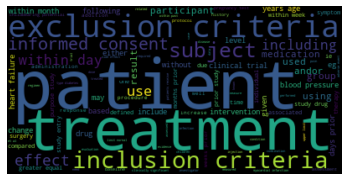

<Figure size 1440x720 with 0 Axes>

In [253]:
X_train['textblock']

wordcloud = WordCloud(max_words=100, width=400, height=200).generate(' '.join(X_train['textblock'].values.tolist()))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.figure(figsize=(20,10))
plt.show()

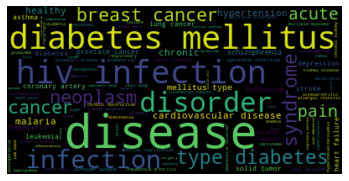

<Figure size 1440x720 with 0 Axes>

In [254]:
wordcloud = WordCloud(max_words=100, width=400, height=200).generate(' '.join(X_train['condition'].values.tolist()))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.figure(figsize=(20,10))
plt.show()

In [304]:
X_train['pmid_len'] = X_train['PMID_tokens'].apply(lambda x: len(x) - x.count(" "))

X_test['pmid_len'] = X_test['PMID_tokens'].apply(lambda x: len(x) - x.count(" "))

C:\Users\Public\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\Public\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [400]:
X_test['pmid_len']

nct_id
NCT02627131    42861
NCT02735213    25608
NCT01819129    23886
NCT00045838    31797
NCT01309997    35529
               ...  
NCT00506831    19402
NCT02049762    90929
NCT01314066    51142
NCT01445106    53538
NCT00486044    22773
Name: pmid_len, Length: 1781, dtype: int64

In [52]:
# combine categorical columns into a dataframe
categorical_columns_train = X_train.select_dtypes('category').columns

X_train_cat = pd.get_dummies(X_train.select_dtypes('category'), columns = categorical_columns_train)

In [305]:
categorical_columns_test = X_test.select_dtypes('category').columns

X_test_cat = pd.get_dummies(X_test.select_dtypes('category'), columns = categorical_columns_test)

In [402]:
#combine int columns into a dataframe
X_train_num = X_train.select_dtypes(np.number)

In [308]:
X_test_num = X_test.select_dtypes(np.number)

In [391]:
#combine tfidf dataframes

tfidf_combined_df = pd.concat([tfidf_int_name_df, tfidf_int_type_df, tfidf_source_df,
                               tfidf_pmid_df, tfidf_condition_df, tfidf_textblock_df], axis =1)

In [367]:
tfidf_combined_test_df = pd.concat([tfidf_int_name_df_test, tfidf_int_type_df_test, tfidf_source_df_test,
                                    tfidf_pmid_df_test, tfidf_condition_test_df, tfidf_textblock_df_test], axis = 1)

In [392]:
tfidf_combined_df.set_index(X_train.index, inplace = True)

In [368]:
tfidf_combined_test_df.set_index(X_test.index, inplace = True)

In [206]:
tfidf_combined_df['success_or_fail'] = y_train

In [211]:
df_false = tfidf_combined_df[tfidf_combined_df['success_or_fail'] == False]
df_true = tfidf_combined_df[tfidf_combined_df['success_or_fail'] == True]

In [320]:
tfidf_combined_test_df

,abacavir sulfate,abciximab placebo,abraxane induction,ace inhibitor,acetaminophen iv,acetaminophen placebo,acetazolamide placebo,acetylsalicylic acid,acid dha,acid ezetimibe,...,years old,years older,years patients,years prior,years study,years time,years years,yet known,york heart,young adults
nct_id,,,,,,,,,,,,,,,,,,,,,
NCT02627131,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
NCT02735213,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.146595,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
NCT01819129,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.058085,0.0
NCT00045838,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.035708,0.0,0.0,0.051574,0.0,0.0,0.0,0.0,0.000000,0.0
NCT01309997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NCT00506831,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
NCT02049762,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
NCT01314066,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0


In [615]:
combined_train_df = pd.concat([X_train_cat, X_train_num, tfidf_combined_df], axis = 1)

In [369]:
combined_test_df = pd.concat([X_test_cat, X_test_num, tfidf_combined_test_df], axis = 1)

Let's examine the new numeric columns we've engineered.

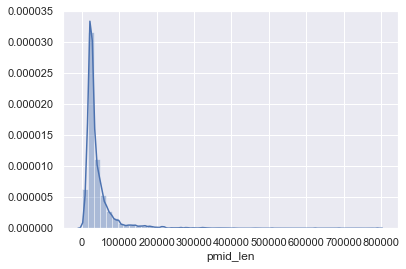

In [574]:
sns.distplot(combined_train_df['pmid_len'])

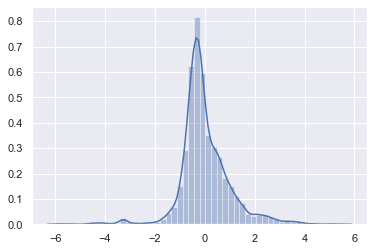

In [573]:
from sklearn.preprocessing import PowerTransformer

power = PowerTransformer()

pmid_len = power.fit_transform(combined_train_df['pmid_len'].values.reshape((-1,1)))

sns.distplot(pmid_len)

In [578]:
combined_train_df['pmid_len'] = pmid_len

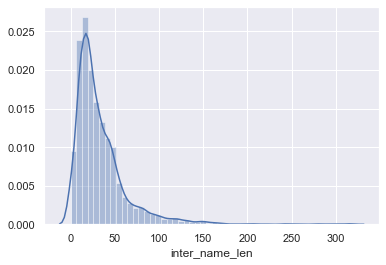

In [579]:
sns.distplot(combined_train_df['inter_name_len'])

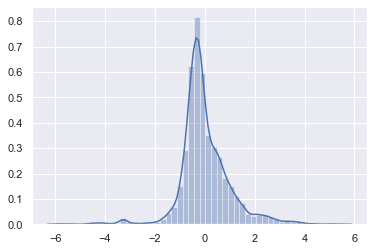

In [580]:
power = PowerTransformer()

inter_name_len = power.fit_transform(combined_train_df['inter_name_len'].values.reshape((-1,1)))

sns.distplot(pmid_len)

In [581]:
combined_train_df['inter_name_len'] = inter_name_len

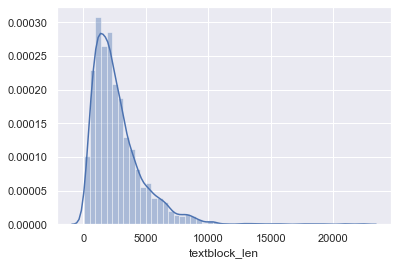

In [583]:
sns.distplot(combined_train_df['textblock_len'])

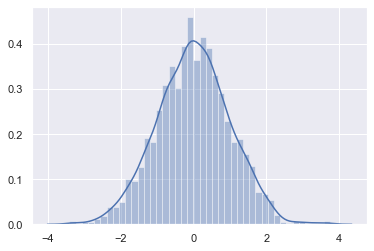

In [584]:
power = PowerTransformer()

textblock_len = power.fit_transform(combined_train_df['textblock_len'].values.reshape((-1,1)))

sns.distplot(textblock_len)

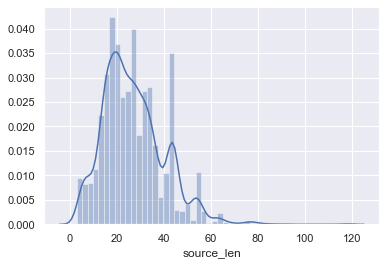

In [585]:
sns.distplot(combined_train_df['source_len'])

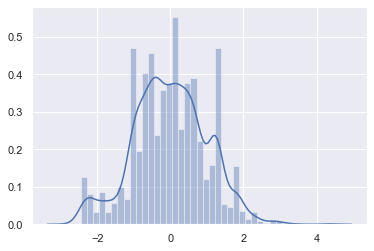

In [586]:
power = PowerTransformer()

source_len = power.fit_transform(combined_train_df['source_len'].values.reshape((-1,1)))

sns.distplot(source_len)

In [587]:
combined_train_df['source_len'] = source_len

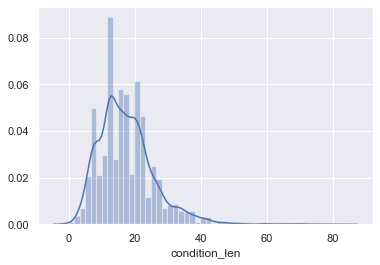

In [588]:
sns.distplot(combined_train_df['condition_len'])

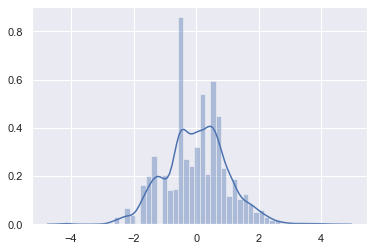

In [589]:
power = PowerTransformer()

condition_len = power.fit_transform(combined_train_df['condition_len'].values.reshape((-1,1)))

sns.distplot(condition_len)

In [590]:
combined_train_df['condition_len'] = condition_len

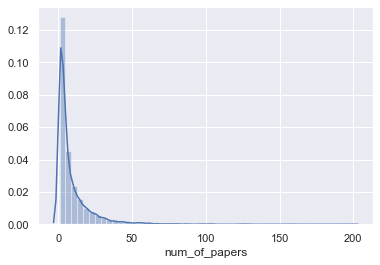

In [594]:
sns.distplot(combined_train_df['num_of_papers'])

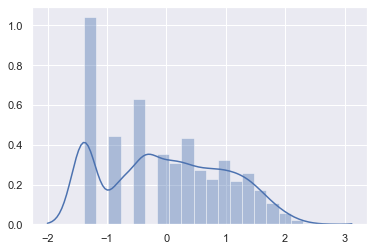

In [598]:
power = PowerTransformer()

num_papers_len = power.fit_transform(combined_train_df['num_of_papers'].values.reshape((-1,1)))

sns.distplot(num_papers_len)

In [599]:
combined_train_df['num_of_papers'] = num_papers_len

In [644]:
combined_train_df = pd.get_dummies(combined_train_df, columns = ['minimum_age', 'maximum_age'])
combined_test_df = pd.get_dummies(combined_test_df, columns = ['minimum_age', 'maximum_age'])

In [650]:
cols_to_drop_test = []
for col in combined_test_df.columns.to_list():
    if col not in combined_train_df.columns.to_list():
        cols_to_drop_test.append(col)

cols_to_drop_train = []
for col in combined_train_df.columns.to_list():
    if col not in combined_test_df.columns.to_list():
        cols_to_drop_train.append(col) 
        
combined_test_df.drop(columns = cols_to_drop_test, inplace = True)  

combined_train_df.drop(columns = cols_to_drop_train, inplace = True)

In [724]:
cols_to_drop_test

[]

### X_train_num.drop(columns = 'textblock_len', inplace = True)

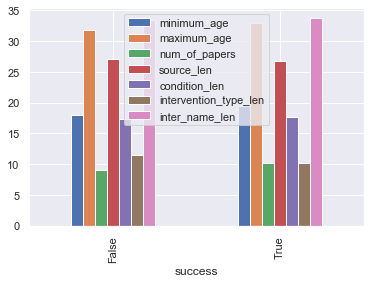

In [260]:
X_train_num.groupby(['success']).mean().plot(kind = 'bar', )

In [604]:
combined_train_df.drop(columns = 'pmid_len_power', inplace = True)
#combined_train_df

In [429]:
from sklearn.decomposition import PCA

pca = PCA(n_components=20)
X_train_pca = pca.fit_transform(combined_train_df)
X_test_pca = pca.transform(combined_test_df)

In [607]:
logreg = LogisticRegression(solver = 'liblinear')

logreg.fit(combined_train_df, y_train)

LogisticRegression(solver='liblinear')

In [608]:
y_pred_test = logreg.predict(combined_test_df)

print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

       False       0.81      1.00      0.90      1447
        True       0.00      0.00      0.00       334

    accuracy                           0.81      1781
   macro avg       0.41      0.50      0.45      1781
weighted avg       0.66      0.81      0.73      1781



In [640]:
combined_train_df['minimum_age'] = combined_train_df['minimum_age'].astype('category')
combined_train_df['maximum_age'] = combined_train_df['maximum_age'].astype('category')

combined_test_df['minimum_age'] = combined_test_df['minimum_age'].astype('category')
combined_test_df['maximum_age'] = combined_test_df['maximum_age'].astype('category')

In [716]:
list(cols_to_drop)

['healthy_volunteers_No',
 'is_fda_regulated_device_Yes',
 'intervention_model_Sequential Assignment',
 'primary_purpose_Educational/Counseling/Training',
 'primary_purpose_Health Services Research',
 'primary_purpose_Other',
 'primary_purpose_Supportive Care',
 'masking_Double (Care Provider, Outcomes Assessor)',
 'maximum_age',
 'allocation_Non-Randomized',
 'masking_Single (Care Provider)',
 'primary_purpose_Diagnostic',
 'intervention_model_Single Group Assignment',
 'intervention_model_Single Group Assignment',
 'intervention_model_Parallel Assignment',
 'intervention_model_Factorial Assignment',
 'masking_Double (Care Provider, Investigator)',
 'primary_purpose_Screening',
 'gender_Female',
 'masking_Triple (Care Provider, Investigator, Outcomes Assessor)',
 'masking_Double (Participant, Investigator)',
 'masking_Single',
 'masking_Triple (Participant, Care Provider, Investigator)']

In [711]:
combined_train_df['healthy_volunteers_No']

nct_id
NCT01720316    1
NCT00297258    1
NCT01384149    1
NCT01267682    1
NCT00331799    1
              ..
NCT00844493    0
NCT00365170    1
NCT00826020    1
NCT00505375    1
NCT01428843    1
Name: healthy_volunteers_No, Length: 3614, dtype: uint8

In [696]:
#num_cols = X_train_num.select_dtypes(np.number).columns.to_list()
num_cols = ['minimum_age', 'maximum_age']
power_cols = ['pmid_len', 'condition_len', 'inter_name_len', 'source_len',
        'textblock_len', 'num_of_papers']
power_pipe = Pipeline([('power', PowerTransformer())])
preprocessor = ColumnTransformer(transformers = [('power', power_pipe, num_cols)],
                                                
                                 remainder = 'passthrough', 
                                 n_jobs=-1)

pipe = imbPipe(steps = [('preprocessor', MinMaxScaler()),
                        #('poly', PolynomialFeatures()),,
                         ('bal', RandomUnderSampler(sampling_strategy = 0.5)),
                        ('bal2', SMOTE(sampling_strategy= 0.7)),
                        #('model', LogisticRegression(class_weight = 'balanced')
                         ('model', SGDClassifier(class_weight='balanced',loss = 'log')
                        )
                         ],
                           verbose = True)

pipe.fit(combined_train_df, y_train)

[Pipeline] ...... (step 1 of 4) Processing preprocessor, total=   1.8s
[Pipeline] ............... (step 2 of 4) Processing bal, total=   0.8s
[Pipeline] .............. (step 3 of 4) Processing bal2, total=  18.8s
[Pipeline] ............. (step 4 of 4) Processing model, total=   1.5s


Pipeline(steps=[('preprocessor', MinMaxScaler()),
                ('bal', RandomUnderSampler(sampling_strategy=0.5)),
                ('bal2', SMOTE(sampling_strategy=0.7)),
                ('model', SGDClassifier(class_weight='balanced', loss='log'))],
         verbose=True)

In [500]:
y_pred = pipe.predict(combined_test_df)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.91      0.85      0.88      1447
        True       0.50      0.63      0.56       334

    accuracy                           0.81      1781
   macro avg       0.70      0.74      0.72      1781
weighted avg       0.83      0.81      0.82      1781



In [676]:
y_pred_test = pipe.predict(combined_test_df)

print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

       False       0.91      0.81      0.86      1447
        True       0.45      0.67      0.54       334

    accuracy                           0.78      1781
   macro avg       0.68      0.74      0.70      1781
weighted avg       0.83      0.78      0.80      1781



In [697]:
y_pred_test = pipe.predict(combined_test_df)

print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

       False       0.90      0.83      0.87      1447
        True       0.46      0.62      0.53       334

    accuracy                           0.79      1781
   macro avg       0.68      0.72      0.70      1781
weighted avg       0.82      0.79      0.80      1781



In [ ]:
#### len(logreg.coef_[0])
features = combined_train_df.columns.to_list()
feat_coeff = []
feat_col = []

In [134]:
for i, coef in enumerate(logreg.coef_[0]):
    feat_coeff.append(coef)
    #feat_col.appen

In [147]:
data = X_train.copy()
data['success'] = y_train
data['success'] = data['success'].astype('int')
data.drop(columns = 'country', inplace = True)

In [101]:
data.corr()

,minimum_age,maximum_age,num_of_papers,success
minimum_age,1.000000,0.196880,0.075541,0.049284
maximum_age,0.196880,1.000000,0.037117,0.013105
num_of_papers,0.075541,0.037117,1.000000,0.034405
success,0.049284,0.013105,0.034405,1.000000


In [154]:
from statsmodels.api import Logit
from statsmodels.formula.api import logit

pred_int = '+'.join(X_train.select_dtypes('number'))+'+'
pred_cat = ')+C('.join(X_train.select_dtypes('category'))
pred_cat = 'C('+pred_cat+')'
formula = 'success'+'~' + pred_int + pred_cat
logreg = logit(formula = '''success ~ minimum_age + maximum_age + num_of_papers + C(healthy_volunteers)
                            + C(is_fda_regulated_drug) + C(is_fda_regulated_device) + C(gender)
                            + C(allocation) + C(intervention_model) + C(primary_purpose)
                            + C(masking)''', data = data, 
              drop_cols= cols_to_drop
              ).fit()
                                             
#outcome = 'price'
#pred_sum = '+'.join(X_train.columns)
#formula = outcome+'~'+ pred_sum
#model = ols(formula = formula, data = data).fit()

Optimization terminated successfully.
         Current function value: 0.463423
         Iterations 6


In [157]:
logreg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                success   No. Observations:                 3614
Model:                          Logit   Df Residuals:                     3596
Method:                           MLE   Df Model:                           17
Date:                Wed, 31 Mar 2021   Pseudo R-squ.:                 0.03014
Time:                        16:10:41   Log-Likelihood:                -1674.8
converged:                       True   LL-Null:                       -1726.9
Covariance Type:            nonrobust   LLR p-value:                 1.530e-14
=========================================================================================================================================================
                                                                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                -1.5832      0.255     -6.202      0.000      -2.084      -1.083
C(is_fda_regulated_drug)[T.Yes]                                                          -0.4205      0.149     -2.830      0.005      -0.712      -0.129
C(gender)[T.Male]                                                                        -0.5500      0.252     -2.182      0.029      -1.044      -0.056
C(allocation)[T.Randomized]                                                               0.6122      0.127      4.821      0.000       0.363       0.861
C(primary_purpose)[T.Prevention]                                                         -0.3181      0.173     -1.839      0.066      -0.657       0.021
C(primary_purpose)[T.Treatment]                                                          -0.4068      0.138     -2.937      0.003      -0.678      -0.135
C(masking)[T.Double (Investigator, Outcomes Assessor)]                                    1.2361      0.553      2.234      0.025       0.152       2.320
C(masking)[T.Double (Participant, Care Provider)]                                         0.6219      0.340      1.827      0.068      -0.045       1.289
C(masking)[T.Double (Participant, Outcomes Assessor)]                                     0.7226      0.317      2.282      0.023       0.102       1.343
C(masking)[T.None (Open Label)]                                                           0.1364      0.135      1.012      0.312      -0.128       0.401
C(masking)[T.Quadruple (Participant, Care Provider, Investigator, Outcomes Assessor)]     0.1608      0.149      1.076      0.282      -0.132       0.454
C(masking)[T.Single (Investigator)]                                                       0.7108      0.332      2.144      0.032       0.061       1.361
C(masking)[T.Single (Outcomes Assessor)]                                                  0.6412      0.220      2.911      0.004       0.209       1.073
C(masking)[T.Single (Participant)]                                                        0.0964      0.258      0.373      0.709      -0.410       0.603
C(masking)[T.Triple (Participant, Care Provider, Outcomes Assessor)]                      0.9564      0.402      2.381      0.017       0.169       1.743
C(masking)[T.Triple (Participant, Investigator, Outcomes Assessor)]                       0.5415      0.240      2.260      0.024       0.072       1.011
minimum_age                                                                               0.0078      0.003      2.222      0.026       0.001       0.015
num_of_papers                                                                             0.0046      0.003      1.497      0.134      -0.001       0.011
=======

In [189]:
logreg.params

Intercept                                                                               -1.583230
C(is_fda_regulated_drug)[T.Yes]                                                         -0.420532
C(gender)[T.Male]                                                                       -0.549988
C(allocation)[T.Randomized]                                                              0.612180
C(primary_purpose)[T.Prevention]                                                        -0.318136
C(primary_purpose)[T.Treatment]                                                         -0.406794
C(masking)[T.Double (Investigator, Outcomes Assessor)]                                   1.236138
C(masking)[T.Double (Participant, Care Provider)]                                        0.621905
C(masking)[T.Double (Participant, Outcomes Assessor)]                                    0.722551
C(masking)[T.None (Open Label)]                                                          0.136410
C(masking)[T.Quadrup

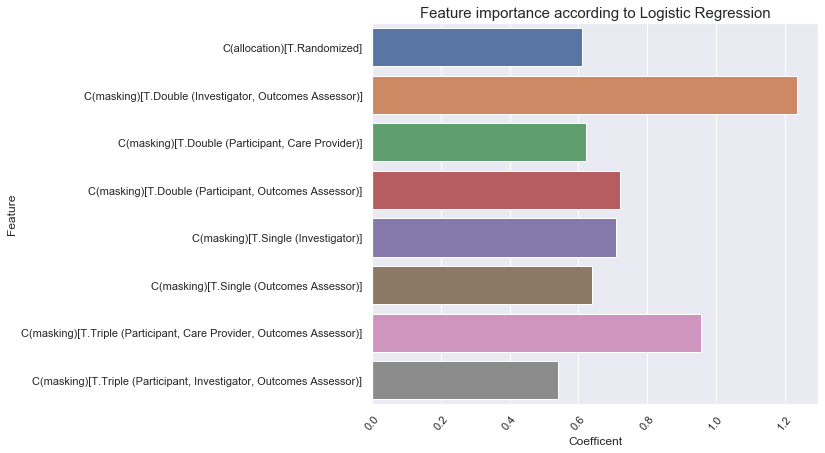

In [202]:
name = []
coefficient = []
for i, coef in enumerate(logreg.params):
    if coef > 0.5:
        #print(i)
        name.append(logreg.params.index[i])
        coefficient.append(coef)
sns.set()      
plt.figure(figsize = (8,7))
sns.barplot(coefficient, name)
plt.title('Feature importance according to Logistic Regression', fontdict={ 'fontsize': 15})
plt.xlabel('Coefficent')
plt.ylabel('Feature')
plt.xticks(rotation = '50')
plt.show();

In [728]:
combined_train_df['success'] = y_train

In [730]:
combined_train_df['success']

nct_id
NCT01720316    False
NCT00297258    False
NCT01384149    False
NCT01267682    False
NCT00331799    False
               ...  
NCT00844493    False
NCT00365170     True
NCT00826020    False
NCT00505375    False
NCT01428843    False
Name: success, Length: 3614, dtype: bool

In [ ]:
combined

In [732]:
successful_df = combined_train_df[combined_train_df['success'] == True]
fail_df = combined_train_df[combined_train_df['success'] == False]

In [ ]:
successful_df[]

In [ ]:
successful_df['masking_Double (Care Provider, Investigator)']

In [151]:
cols_to_drop = ['C(healthy_volunteers)[T.No]', 'C(is_fda_regulated_device)[T.Yes]',
                'C(intervention_model)[T.Sequential Assignment]', 'C(primary_purpose)[T.Educational/Counseling/Training]',
                'C(primary_purpose)[T.Health Services Research]', 'C(primary_purpose)[T.Other]',
                'C(primary_purpose)[T.Supportive Care]', 'C(masking)[T.Double (Care Provider, Outcomes Assessor)]',
                'maximum_age', 'C(allocation)[T.Non-Randomized]', 'C(masking)[T.Single (Care Provider)]',
                'C(primary_purpose)[T.Diagnostic]', 'C(intervention_model)[T.Single Group Assignment]',
                'C(intervention_model)[T.Single Group Assignment]','C(intervention_model)[T.Parallel Assignment]',
                'C(intervention_model)[T.Factorial Assignment]', 'C(masking)[T.Double (Care Provider, Investigator)]',
                'C(primary_purpose)[T.Screening]', 'C(gender)[T.Female]',
                'C(masking)[T.Triple (Care Provider, Investigator, Outcomes Assessor)]',
                'C(masking)[T.Double (Participant, Investigator)]', 'C(masking)[T.Single]',
                'C(masking)[T.Triple (Participant, Care Provider, Investigator)]'
                
            
                ]


In [726]:
cols_to_drop = ['healthy_volunteers_No', 'is_fda_regulated_device_Yes','intervention_model_Sequential Assignment', 'primary_purpose_Educational/Counseling/Training',
                'primary_purpose_Health Services Research', 'C(primary_purpose)[T.Other]',
                'C(primary_purpose)[T.Supportive Care]', 'C(masking)[T.Double (Care Provider, Outcomes Assessor)]',
                'maximum_age', 'C(allocation)[T.Non-Randomized]', 'C(masking)[T.Single (Care Provider)]',
                'C(primary_purpose)[T.Diagnostic]', 'C(intervention_model)[T.Single Group Assignment]',
                'C(intervention_model)[T.Single Group Assignment]','C(intervention_model)[T.Parallel Assignment]',
                'C(intervention_model)[T.Factorial Assignment]', 'C(masking)[T.Double (Care Provider, Investigator)]',
                'C(primary_purpose)[T.Screening]', 'C(gender)[T.Female]',
                'C(masking)[T.Triple (Care Provider, Investigator, Outcomes Assessor)]',
                'C(masking)[T.Double (Participant, Investigator)]', 'C(masking)[T.Single]',
                'C(masking)[T.Triple (Participant, Care Provider, Investigator)]']
cols_to_drop = [x.replace('C(', '') for x in cols_to_drop]
cols_to_drop = [x.replace(')[T.', '_') for x in cols_to_drop]
cols_to_drop = [x.replace(']', '') for x in cols_to_drop]
cols_to_drop

['healthy_volunteers_No',
 'is_fda_regulated_device_Yes',
 'intervention_model_Sequential Assignment',
 'primary_purpose_Educational/Counseling/Training',
 'primary_purpose_Health Services Research',
 'primary_purpose_Other',
 'primary_purpose_Supportive Care',
 'masking_Double (Care Provider, Outcomes Assessor)',
 'maximum_age',
 'allocation_Non-Randomized',
 'masking_Single (Care Provider)',
 'primary_purpose_Diagnostic',
 'intervention_model_Single Group Assignment',
 'intervention_model_Single Group Assignment',
 'intervention_model_Parallel Assignment',
 'intervention_model_Factorial Assignment',
 'masking_Double (Care Provider, Investigator)',
 'primary_purpose_Screening',
 'gender_Female',
 'masking_Triple (Care Provider, Investigator, Outcomes Assessor)',
 'masking_Double (Participant, Investigator)',
 'masking_Single',
 'masking_Triple (Participant, Care Provider, Investigator)']

In [153]:
logreg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                success   No. Observations:                 3614
Model:                          Logit   Df Residuals:                     3574
Method:                           MLE   Df Model:                           39
Date:                Wed, 31 Mar 2021   Pseudo R-squ.:                 0.03758
Time:                        16:09:39   Log-Likelihood:                -1662.0
converged:                      False   LL-Null:                       -1726.9
Covariance Type:            nonrobust   LLR p-value:                 1.106e-11
=========================================================================================================================================================
                                                                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                -1.7612      0.506     -3.479      0.001      -2.753      -0.769
C(healthy_volunteers)[T.No]                                                              -0.0515      0.122     -0.421      0.674      -0.292       0.189
C(is_fda_regulated_drug)[T.Yes]                                                          -0.4297      0.151     -2.853      0.004      -0.725      -0.134
C(is_fda_regulated_device)[T.Yes]                                                         0.0607      0.683      0.089      0.929      -1.277       1.399
C(gender)[T.Female]                                                                      -0.1999      0.175     -1.140      0.254      -0.544       0.144
C(gender)[T.Male]                                                                        -0.5979      0.257     -2.325      0.020      -1.102      -0.094
C(allocation)[T.Non-Randomized]                                                           0.0543      0.225      0.242      0.809      -0.386       0.495
C(allocation)[T.Randomized]                                                               0.5131      0.255      2.013      0.044       0.014       1.013
C(intervention_model)[T.Factorial Assignment]                                            -0.4593      0.329     -1.396      0.163      -1.104       0.186
C(intervention_model)[T.Parallel Assignment]                                             -0.2333      0.156     -1.492      0.136      -0.540       0.073
C(intervention_model)[T.Sequential Assignment]                                          -20.0180   7694.409     -0.003      0.998   -1.51e+04    1.51e+04
C(intervention_model)[T.Single Group Assignment]                                         -0.3592      0.253     -1.421      0.155      -0.855       0.136
C(primary_purpose)[T.Diagnostic]                                                          0.1506      0.362      0.416      0.678      -0.560       0.861
C(primary_purpose)[T.Educational/Counseling/Training]                                   -17.6488    1.7e+04     -0.001      0.999   -3.33e+04    3.32e+04
C(primary_purpose)[T.Health Services Research]                                           -0.0182      0.553     -0.033      0.974      -1.102       1.066
C(primary_purpose)[T.Other]                                                              -0.1305      0.431     -0.303      0.762      -0.975       0.714
C(primary_purpose)[T.Prevention]                                                         -0.1831      0.286     -0.641      0.522      -0.743       0.377
C(primary_purpose)[T.Screening]                                                           0.8337      0.706      1.182      0.237      -0.549       2.217
C(prima

In [197]:
X_train.loc[:, 'intervention_type'] = X_train['intervention_type'].map(lambda x: ' '.join(x))
X_train.loc[:, 'intervention_name'] = X_train['intervention_name'].map(lambda x: ' '.join(x))
X_train.loc[:, 'textblock'] = X_train.loc[:, 'textblock'].str[0]

X_test.loc[:, 'intervention_type'] = X_test['intervention_type'].map(lambda x: ' '.join(x))
X_test.loc[:, 'intervention_name'] = X_test['intervention_name'].map(lambda x: ' '.join(x))
X_test.loc[:, 'textblock'] = X_test.loc[:, 'textblock'].str[0]

C:\Users\Public\Anaconda3\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


We will combine the text data to provide the vectorizers with as much data as possible.

In [369]:
X_train.loc[:, 'combined_text'] = X_train['source']+' '+ X_train['condition']+ ' '+ X_train['textblock'] + ' ' +  X_train['intervention_type'] + ' ' +  X_train['intervention_name'] + ' '+ X_train['PMID_tokens']
X_train.loc[:, 'combined_text'] = X_train['combined_text'].map(get_tokens)

X_test.loc[:, 'combined_text'] = X_test['source']+ ' '+X_test['condition']+' '+X_test['textblock']+' '+X_test['intervention_type']+' '+X_test['intervention_name']+' '+X_test['PMID_tokens']
X_test.loc[:, 'combined_text'] = X_test['combined_text'].map(get_tokens)

C:\Users\Public\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\Public\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [249]:
combined_text = X_train['combined_text'].to_numpy()
combined_text = [w for sublist in combined_text for w in sublist]


In [251]:
from  nltk import FreqDist
freqdist = FreqDist(combined_text)

most_common = freqdist.most_common(200)

In [253]:
most_common

[('patients', 227773),
 ('study', 134263),
 ('et', 112246),
 ('al', 112003),
 ('treatment', 104628),
 ('group', 87718),
 ('cells', 78083),
 ('http', 73976),
 ('clinical', 63872),
 ('cancer', 59822),
 ('disease', 58204),
 ('data', 58102),
 ('may', 51129),
 ('cell', 48516),
 ('therapy', 47861),
 ('analysis', 46626),
 ('use', 46161),
 ('studies', 45790),
 ('results', 44958),
 ('table', 44527),
 ('diabetes', 43972),
 ('trial', 43504),
 ('also', 42777),
 ('blood', 42719),
 ('risk', 42582),
 ('using', 42111),
 ('used', 40958),
 ('effects', 40693),
 ('one', 40593),
 ('time', 39959),
 ('two', 39013),
 ('levels', 38319),
 ('response', 38192),
 ('control', 38110),
 ('effect', 37902),
 ('patient', 37227),
 ('dose', 36969),
 ('subjects', 36588),
 ('baseline', 36474),
 ('mean', 35703),
 ('compared', 35392),
 ('significant', 35204),
 ('med', 34456),
 ('groups', 34283),
 ('human', 33548),
 ('fig', 33005),
 ('research', 32419),
 ('placebo', 30873),
 ('medical', 30641),
 ('associated', 30437),
 ('pain'

In [371]:
X_test.loc[:, 'intervention_model'] = X_test.loc[:,'intervention_model'].astype('category')
X_test.loc[:, 'healthy_volunteers'] = X_test.loc[:, 'healthy_volunteers'].astype('category')
X_test.loc[:, 'masking'] = X_test.loc[:, 'masking'].astype('category')
X_test.loc[:, 'primary_purpose'] = X_test.loc[:, 'primary_purpose'].astype('category')
X_test.loc[:, 'allocation'] = X_test.loc[:, 'allocation'].astype('category')
X_test.loc[:, 'gender'] = X_test.loc[:, 'gender'].astype('category')

X_test.loc[:, 'enrollment'].fillna(enrollment_mean, inplace = True)
X_test.loc[:, 'enrollment'] = X_test.loc[:,'enrollment'].astype(int)
X_test.loc[:,'minimum_age'] = X_test.loc[:, 'minimum_age'].map(change_age).to_numpy()
X_test.loc[:, 'maximum_age'] = X_test.loc[:, 'maximum_age'].map(change_age).to_numpy()
X_test.loc[:, 'has_expanded_access'] = X_test.loc[:, 'has_expanded_access'].astype('category')
X_test.loc[:,'country'] = X_test.loc[:, 'country'].astype('category')
X_test.loc[:, 'maximum_age'] = X_test.loc[:,'maximum_age'].astype(int)
X_test.loc[:, 'minimum_age'] = X_test.loc[:,'minimum_age'].astype(int)


Let's create a model using only the text. I'd like to establish a bit of a baseline of what numbers we are going to see when running models down the line. We want to focus on a high precision.

In [263]:
vectorizer = TfidfVectorizer()
tf_idf_train = vectorizer.fit_transform(X_train['combined_text'].map(lambda x: ' '.join(x)))
tf_idf_test = vectorizer.transform(X_test['combined_text'].map(lambda x: ' '.join(x)))

In [264]:
tf_idf_train.shape

(3614, 426391)

In [279]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
nb_classifier = MultinomialNB()
rf_classifier = RandomForestClassifier(n_estimators= 100)
logreg = LogisticRegression()

nb_classifier.fit(tf_idf_train, y_train)
nb_train_preds = nb_classifier.predict(tf_idf_train)
nb_test_preds = nb_classifier.predict(tf_idf_test)


rf_classifier.fit(tf_idf_train, y_train)
rf_train_preds = rf_classifier.predict(tf_idf_train)
rf_test_preds = rf_classifier.predict(tf_idf_test)

logreg.fit(tf_idf_train,y_train)
lr_test = logreg.predict(tf_idf_test)

nb_train_score = accuracy_score(y_train, nb_train_preds)
nb_test_score = accuracy_score(y_test, nb_test_preds)
rf_train_score = accuracy_score(y_train, rf_train_preds)
rf_test_score = accuracy_score(y_test, rf_test_preds)

print("Multinomial Naive Bayes")
print("Training Accuracy: {:.4} \t\t Testing Accuracy: {:.4}".format(nb_train_score, nb_test_score))
print("")
print('-'*70)
print("")
print('Random Forest')
print("Training Accuracy: {:.4} \t\t Testing Accuracy: {:.4}".format(rf_train_score, rf_test_score))

Multinomial Naive Bayes
Training Accuracy: 0.8157 		 Testing Accuracy: 0.8125

----------------------------------------------------------------------

Random Forest
Training Accuracy: 1.0 		 Testing Accuracy: 0.8209


In [276]:
print(classification_report(y_test, rf_test_preds))

              precision    recall  f1-score   support

       False       0.82      0.99      0.90      1447
        True       0.71      0.07      0.12       334

    accuracy                           0.82      1781
   macro avg       0.77      0.53      0.51      1781
weighted avg       0.80      0.82      0.75      1781



In [282]:
print(classification_report(lr_test, y_test))

              precision    recall  f1-score   support

       False       1.00      0.82      0.90      1756
        True       0.06      0.76      0.11        25

    accuracy                           0.82      1781
   macro avg       0.53      0.79      0.50      1781
weighted avg       0.98      0.82      0.89      1781



In [178]:
logreg = LogisticRegression()

logreg.fit(tokens, y_train)

logreg.predict(test_tokens)

array([False, False, False, ..., False, False, False])

In [179]:
y_pred = logreg.predict(test_tokens)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.81      0.97      0.88      1447
        True       0.20      0.04      0.06       334

    accuracy                           0.79      1781
   macro avg       0.50      0.50      0.47      1781
weighted avg       0.70      0.79      0.73      1781



In [295]:
X_train['combined_text'] = X_train['combined_text'].map(lambda x: ' '.join(x))

C:\Users\Public\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [372]:
X_train.drop(['source', 'condition', 'textblock', 'intervention_type', 
              'intervention_name','PMID_tokens'],
             axis = 1, inplace = True)
X_test.drop(['source', 'condition', 'textblock', 'intervention_type', 
              'intervention_name', 'PMID_tokens'],
             axis = 1, inplace = True)

C:\Users\Public\Anaconda3\lib\site-packages\pandas\core\frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [358]:
X_train['combined_text']= X_train['combined_text'].map(lambda x: x.split(' '))
X_test['combined_text']= X_test['combined_text'].map(lambda x: x.split(' '))

C:\Users\Public\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\Public\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Let's create a more streamlined process since we will want to deploy our model in the future. We will also look at ways to improve the accuracy of the model. One way we can try and improve the accuracy of the model is by not combining the text into one column. We will keep them seperate and apply vectorization to each column to see if that improves our scores. Let's also define which measure of accuracy we want to focus on. 

Take a look below. In an imbalanced classification, you can have a high overall accuracy and not necessarily predict the under represented column well. If we accurately predict all False labels and no True labels, we can land an accuracy score over 75%.

What we need to focus on is the precision score of the True labels. We want to limit the amount of false positives we classify.

In [375]:
cat_cols = ['has_expanded_access', 'gender', 'healthy_volunteers', 'country',
            'allocation', 'intervention_model', 'masking', 'is_fda_regulated_drug',
            'is_fda_regulated_device', 'primary_purpose']
num_cols = ['minimum_age', 'maximum_age', 'enrollment', 'num_of_papers']


cat_pipe = Pipeline([('imputer', SimpleImputer(strategy = 'constant', fill_value = 'missing')),
                     ('ohe', OneHotEncoder(handle_unknown = 'ignore'))])


num_pipe = Pipeline([('imputer', SimpleImputer(strategy = 'median')),
                     ('scaler', MinMaxScaler())])

word_pipe = Pipeline([('vectorizer', D2VTransformer(dm = 1, min_count = 5, dbow_words= 1))])

preprocessor = ColumnTransformer(transformers = [('num', num_pipe, num_cols),
                                                 ('text', word_pipe, 'combined_text'),
                                                 ('cat', cat_pipe, cat_cols),
                                                 #('poly', poly_pipe, inter)
                                                 ], remainder = 'drop',
                                 n_jobs=-1)

pipe = imbPipe(steps = [('preprocessor', preprocessor),
                        #('poly', PolynomialFeatures()),
                         #('bal', RandomUnderSampler(sampling_strategy = 0.4)),
                        ('bal2', SMOTE(sampling_strategy= 0.3)),
                        ('model', LogisticRegression(solver = 'liblinear', C = 1))],
                           verbose = True)

pipe.fit(X_train, y_train)

[Pipeline] ...... (step 1 of 3) Processing preprocessor, total= 6.8min
[Pipeline] .............. (step 2 of 3) Processing bal2, total=   0.5s
[Pipeline] ............. (step 3 of 3) Processing model, total=   0.7s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['minimum_age', 'maximum_age',
                                                   'enrollment',
                                                   'num_of_papers']),
                                                 ('text',
                                                  Pipeline(steps=[('vectorizer',
                                                                   D2VTransformer(dbow_words=1))]),
                                                  'combined_text')

In [306]:
X_test['combined_text'] = X_test['combined_text'].map(lambda x: ' '.join(x))

C:\Users\Public\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [307]:
y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.83      0.99      0.90      1447
        True       0.73      0.14      0.24       334

    accuracy                           0.83      1781
   macro avg       0.78      0.57      0.57      1781
weighted avg       0.81      0.83      0.78      1781



In [309]:
y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.84      0.98      0.90      1447
        True       0.72      0.17      0.27       334

    accuracy                           0.83      1781
   macro avg       0.78      0.58      0.59      1781
weighted avg       0.81      0.83      0.79      1781



In [376]:
y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.87      0.91      0.89      1447
        True       0.49      0.39      0.43       334

    accuracy                           0.81      1781
   macro avg       0.68      0.65      0.66      1781
weighted avg       0.79      0.81      0.80      1781



Let's try a different approach. Let's keep the text columns seperate to see if there is a difference in the accuracy of the models.

In [328]:
y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.85      0.97      0.91      1447
        True       0.65      0.26      0.37       334

    accuracy                           0.84      1781
   macro avg       0.75      0.61      0.64      1781
weighted avg       0.81      0.84      0.81      1781



In [325]:
y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.85      0.97      0.91      1447
        True       0.65      0.25      0.37       334

    accuracy                           0.83      1781
   macro avg       0.75      0.61      0.64      1781
weighted avg       0.81      0.83      0.80      1781



[Pipeline] ...... (step 1 of 3) Processing preprocessor, total=  32.8s
[Pipeline] .............. (step 2 of 3) Processing bal2, total=   1.1s
[Pipeline] ............. (step 3 of 3) Processing model, total=   8.3s
AUC for 0.2: 0.802676609462485
-------------------------------------------------------------------------------------
[Pipeline] ...... (step 1 of 3) Processing preprocessor, total=  35.3s
[Pipeline] .............. (step 2 of 3) Processing bal2, total=   1.5s
[Pipeline] ............. (step 3 of 3) Processing model, total=  11.2s
AUC for 0.25: 0.8035559840926303
-------------------------------------------------------------------------------------
[Pipeline] ...... (step 1 of 3) Processing preprocessor, total=  25.5s
[Pipeline] .............. (step 2 of 3) Processing bal2, total=   1.1s
[Pipeline] ............. (step 3 of 3) Processing model, total=   6.8s
AUC for 0.33: 0.8065665490028927
-------------------------------------------------------------------------------------
[Pipel

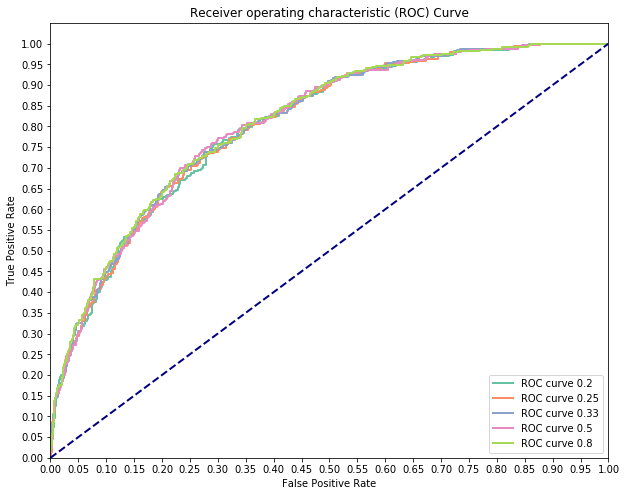

In [338]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

%matplotlib inline
ratios = [ 0.3, 0.6, 0.5, .7, .9]
names = ['0.2', '0.25', '0.33','0.5','0.8','even']
colors = sns.color_palette('Set2')

plt.figure(figsize=(10, 8))

for n, ratio in enumerate(ratios):
    #smote = SMOTE(sampling_strategy=ratio, random_state=42)
    #X_train_resampled, y_train_resampled = smote.fit_sample(X_train, y_train)
    pipe = imbPipe(steps = [('preprocessor', preprocessor),
                        #('poly', PolynomialFeatures()),
                         #('bal', RandomUnderSampler(sampling_strategy = 0.4)),
                        ('bal2', SMOTE(sampling_strategy= ratio)),
                         ('model', LogisticRegression(solver = 'liblinear', C = 1))],
               verbose = True)

    pipe.fit(X_train, y_train)
    
    
    # Predict
    y_hat_test = pipe.predict(X_test)

    y_score = pipe.decision_function(X_test)

    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    print('AUC for {}: {}'.format(names[n], auc(fpr, tpr)))
    print('-------------------------------------------------------------------------------------')
    lw = 2
    plt.plot(fpr, tpr, color=colors[n],
             lw=lw, label='ROC curve {}'.format(names[n]))

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [14]:
def get_tokens(tokens):
    
    tokens = word_tokenize(tokens)
    #split text in words and implement lower case
    tokens = [word.lower() for word in tokens]
   # hyphen = '-'
    #tokens = [word+word if word.endswith(hyphen) else word for word in tokens]
    tokens = [w for w in tokens if not w == ',']
    
    #remove http
    tokens = [re.sub(r'http\S+', '',w) for w in tokens]
    
    # combine hyphenated words
    tok = []
    tokens_to_remove= []
    for n,w in enumerate(tokens):
        if re.match('(.)*[-]$', w):
            #w = w.rstrip('-')
            w = w.replace('-', ' ')
            if n+1 ==len(tokens):
                next
            else:
                w = w + tokens[n+1]
            tokens_to_remove.append(n+1)
        tok.append(w)
       # if n+1 == len(tokens):
        #    tok.append(w)
        #else:
         #   tok.append(w)
            
    tok = [w for i, w in enumerate(tok) if i not in tokens_to_remove]
    
    
    #remove punctuation from each word
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tok]

    #remove remaining words that are not alphabetic
    words = [word for word in stripped if word.isalpha()] 
    #words = stripped
    #filter out stopwords
    stop_words = set(stopwords.words('english'))
    #letters = re.search([a-zA-Z])
    words = [w for w in words if not w in stop_words]
    #
    toke = []
    
    #remove single characters
    for w in words:
        if len(w) == 1:
            if re.match('[a-z]', w):
                next
        else:
            toke.append(w)         
    
    return toke

In [74]:
X_train['textblock'].map(get_tokens)

nct_id
NCT01720316    [purpose, study, assess, efficacy, oral, glyci...
NCT00297258    [purpose, study, evaluate, activity, tolerabil...
NCT01384149    [purpose, study, evaluate, advantages, disadva...
NCT01267682    [purpose, study, test, effectiveness, cognitiv...
NCT00331799    [purpose, study, explore, benefits, duloxetine...
                                     ...                        
NCT00844493    [study, validate, model, testing, new, vaccine...
NCT00365170    [trial, conducted, europe, middle, east, north...
NCT00826020    [purpose, study, determine, established, paren...
NCT00505375    [purpose, study, determine, whether, treatment...
NCT01428843    [anemia, frequently, extradigestive, symptom, ...
Name: textblock, Length: 3614, dtype: object

In [381]:
tokenized_cols = ['source', 'condition','textblock','intervention_type',
                  'intervention_name']

cat_cols = ['has_expanded_access', 'gender', 'healthy_volunteers', 'country',
            'allocation', 'intervention_model', 'masking', 'is_fda_regulated_drug',
            'is_fda_regulated_device', 'primary_purpose']
num_cols = ['minimum_age', 'maximum_age', 'num_of_papers']

def change_datatype(df, datatype, cols):
    for col in cols:
        if col == 'minimum_age' or col == 'maximum_age':
            df.loc[:, col] = df.loc[:, col].map(change_age)
        df.loc[:, col] = df.loc[:, col].astype(datatype)    
    return df

def split_words_col(df, y):
    cols = ['source','condition', 'PMID_tokens']
    other_cols = ['intervention_type', 'intervention_name', 'textblock']
    for col in cols:
        df.loc[:, col] =df[col].map(lambda x: x.split(' '))
    for col in other_cols:
        df.loc[:, col] = df[col]
    return df

def tokenize_col(df, cols):
    extra_step = ['intervention_name', 'intervention_type', 'textblock', 'source', 'condition']
    for col in cols:
        if col in extra_step: 
            df.loc[:, col] = df.loc[:, col].map(lambda x:' '.join(x))    
        df.loc[:, col] = df.loc[:, col].map(get_tokens)  
    return df

def get_tokens(tokens):
    
    tokens = word_tokenize(tokens)
    #split text in words and implement lower case
    tokens = [word.lower() for word in tokens]
   # hyphen = '-'
    #tokens = [word+word if word.endswith(hyphen) else word for word in tokens]
    tokens = [w for w in tokens if not w == ',']
    
    #remove http
    tokens = [re.sub(r'http\S+', '',w) for w in tokens]
    
    # combine hyphenated words
    tok = []
    tokens_to_remove= []
    for n,w in enumerate(tokens):
        if re.match('(.)*[-]$', w):
            #w = w.rstrip('-')
            w = w.replacedef get_tokens(tokens):
    
    tokens = word_tokenize(tokens)
    #split text in words and implement lower case
    tokens = [word.lower() for word in tokens]
   # hyphen = '-'
    #tokens = [word+word if word.endswith(hyphen) else word for word in tokens]
    tokens = [w for w in tokens if not w == ',']
    
    #remove http
    tokens = [re.sub(r'http\S+', '',w) for w in tokens]
    
    # combine hyphenated words
    tok = []
    tokens_to_remove= []
    for n,w in enumerate(tokens):
        if re.match('(.)*[-]$', w):
            w = w.rstrip('-')
            if n+1 ==len(tokens):
                next
            else:
                w = w + tokens[n+1]
            tokens_to_remove.append(n+1)
        tok.append(w)
       # if n+1 == len(tokens):
        #    tok.append(w)
        #else:
         #   tok.append(w)
            
    tok = [w for i, w in enumerate(tok) if i not in tokens_to_remove]
    
    
    #remove punctuation from each word
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tok]

    #remove remaining words that are not alphabetic
    words = [word for word in stripped if word.isalpha()] 
    #words = stripped
    #filter out stopwords
    stop_words = set(stopwords.words('english'))
    #letters = re.search([a-zA-Z])
    words = [w for w in words if not w in stop_words]
    #
    toke = []
    
    #remove single characters
    for w in words:
        if len(w) == 1:
            if re.match('[a-z]', w):
                next
        else:
            toke.append(w)         
    
    return toke
            if n+1 ==len(tokens):
                next
            else:
                w = w + tokens[n+1]
            tokens_to_remove.append(n+1)
        tok.append(w)
       # if n+1 == len(tokens):
        #    tok.append(w)
        #else:
         #   tok.append(w)
            
    tok = [w for i, w in enumerate(tok) if i not in tokens_to_remove]
    
    
    #remove punctuation from each word
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tok]

    #remove remaining words that are not alphabetic
    words = [word for word in stripped if word.isalpha()] 
    #words = stripped
    #filter out stopwords
    stop_words = set(stopwords.words('english'))
    #letters = re.search([a-zA-Z])
    words = [w for w in words if not w in stop_words]
    #
    toke = []
    
    #remove single characters
    for w in words:
        if len(w) == 1:
            if re.match('[a-z]', w):
                next
        else:
            toke.append(w)         
    
    return toke

#split_words_col(X_train, y_train)
#split_words_col(X_test, y_test)


change_datatype(X_train, 'category', cat_cols)
change_datatype(X_train, np.number, num_cols)
tokenize_col(X_train, tokenized_cols)

change_datatype(X_test, 'category', cat_cols)
change_datatype(X_test, np.number, num_cols)
tokenize_col(X_test, tokenized_cols)


X_train.loc[:,'intervention_name'] = X_train['intervention_name'].map(lambda x: ' '.join(x))
X_train.loc[:,'intervention_type'] = X_train['intervention_type'].map(lambda x: ' '.join(x))
X_train.loc[:,'condition'] = X_train['condition'].map(lambda x: ' '.join(x))
X_train.loc[:,'source'] = X_train['source'].map(lambda x: ' '.join(x))
X_train.loc[:, 'textblock'] = X_train['textblock'].map(lambda x: ' '.join(x))
X_train.loc[:, 'PMID_tokens'] = X_train['PMID_tokens'].map(lambda x: get_tokens(' '.join(x)))
X_train.loc[:, 'PMID_tokens'] = X_train['PMID_tokens'].map(lambda x: ' '.join(x))

X_test.loc[:,'intervention_name'] = X_test['intervention_name'].map(lambda x: ' '.join(x))
X_test.loc[:,'intervention_type'] = X_test['intervention_type'].map(lambda x: ' '.join(x))
X_test.loc[:,'condition'] = X_test['condition'].map(lambda x: ' '.join(x))
X_test.loc[:,'source'] = X_test['source'].map(lambda x: ' '.join(x))
X_test.loc[:, 'textblock'] = X_test['textblock'].map(lambda x: ' '.join(x))
X_test.loc[:, 'PMID_tokens'] = X_test['PMID_tokens'].map(lambda x: get_tokens(' '.join(x)))
X_test.loc[:, 'PMID_tokens'] = X_test['PMID_tokens'].map(lambda x: ' '.join(x))





#for col in ['PMID']:
 #   X_train.loc[:, col] = X_train[col].map(lambda x: x.split(' '))
  #  X_test.loc[:, col] = X_test[col].map(lambda x : x.split(' '))


C:\Users\Public\Anaconda3\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


MemoryError: 

In [368]:
X_train.loc[:, 'textblock'] = X_train['textblock'].map(lambda x: ' '.join(x))
X_train.loc[:, 'PMID_tokens'] = X_train['PMID_tokens'].map(lambda x: ' '.join(x))

X_test.loc[:, 'textblock'] = X_test['textblock'].map(lambda x: ' '.join(x))
X_test.loc[:, 'PMID_tokens'] = X_test['PMID_tokens'].map(lambda x: ' '.join(x))

nct_id
NCT02627131    hindawi publishing corporation stem cells inte...
NCT02735213    email karger kargercom mini review ophthalmic ...
NCT01819129    faster aspart versus insulin aspart part basal...
NCT00045838    proc nati acad sci usa vol pp december medical...
NCT01309997    cancer therapy clinical randomized phase ii cr...
                                     ...                        
NCT00506831    systemic cell typespecific gene expression pat...
NCT02049762    ticagrelor versus clopidogrel patients acute c...
NCT01314066    incidence outcomes acute lung injury engl med ...
NCT01445106    research article journal clinical investigatio...
NCT00486044    simvastatin strongly reduces levels alzheimer ...
Name: PMID_tokens, Length: 1781, dtype: object

In [360]:
X_train.loc[:, 'PMID_tokens'] = X_train['PMID_tokens'].map(lambda x: get_tokens(' '.join(x)))
X_test.loc[:, 'PMID_tokens'] = X_test['PMID_tokens'].map(lambda x: get_tokens(' '.join(x)))

C:\Users\Public\Anaconda3\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [17]:
X_train.loc[:,'intervention_name'] = X_train['intervention_name'].map(lambda x: ' '.join(x))
X_train.loc[:,'intervention_type'] = X_train['intervention_type'].map(lambda x: ' '.join(x))
X_train.loc[:,'condition'] = X_train['condition'].map(lambda x: ' '.join(x))
X_train.loc[:,'source'] = X_train['source'].map(lambda x: ' '.join(x))

X_test.loc[:,'intervention_name'] = X_test['intervention_name'].map(lambda x: ' '.join(x))
X_test.loc[:,'intervention_type'] = X_test['intervention_type'].map(lambda x: ' '.join(x))
X_test.loc[:,'condition'] = X_test['condition'].map(lambda x: ' '.join(x))
X_test.loc[:,'source'] = X_test['source'].map(lambda x: ' '.join(x))

C:\Users\Public\Anaconda3\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [140]:
X_copy = X.copy()
y_copy = y.copy()

split_words_col(X_copy, y_copy)

change_datatype(X_copy, 'category', cat_cols)
change_datatype(X_copy, np.number, num_cols)
tokenize_col(X_copy, tokenized_cols)

X_copy.loc[:,'intervention_name'] = X_copy['intervention_name'].map(lambda x: ' '.join(x))
X_copy.loc[:,'intervention_type'] = X_copy['intervention_type'].map(lambda x: ' '.join(x))
X_copy.loc[:,'condition'] = X_copy['condition'].map(lambda x: ' '.join(x))
X_copy.loc[:,'source'] = X_copy['source'].map(lambda x: ' '.join(x))

X_copy.loc[:, 'PMID_tokens'] = X_copy['PMID_tokens'].map(lambda x: ' '.join(x))
X_copy.loc[:, 'PMID_tokens'] = X_copy['PMID_tokens'].map(get_tokens)

X_copy.loc[:, 'PMID_tokens'] = X_copy['PMID_tokens'].map(lambda x: ' '.join(x))
X_copy.loc[:, 'textblock'] = X_copy['textblock'].map(lambda x: ' '.join(x))

In [343]:
X_train.loc[:, 'PMID_tokens'] = X_train['PMID_tokens'].map(lambda x: ' '.join(x))
X_train.loc[:, 'textblock'] = X_train['textblock'].map(lambda x: ' '.join(x))

X_test.loc[:, 'PMID_tokens'] = X_test['PMID_tokens'].map(lambda x: ' '.join(x))
X_test.loc[:, 'textblock'] = X_test['textblock'].map(lambda x: ' '.join(x))

C:\Users\Public\Anaconda3\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [37]:
X_train.loc[:, 'PMID_tokens'] = X_train['PMID_tokens'].map(lambda x: ' '.join(x))
X_test.loc[:, 'PMID_tokens'] = X_test['PMID_tokens'].map(lambda x: ' '.join(x))

X_train.loc[:, 'PMID_tokens'] = X_train['PMID_tokens'].map(get_tokens)
X_test.loc[:, 'PMID_tokens'] = X_test['PMID_tokens'].map(get_tokens)

X_train.loc[:, 'PMID_tokens'] = X_train['PMID_tokens'].map(lambda x: ' '.join(x))
X_train.loc[:, 'textblock'] = X_train['textblock'].map(lambda x: ' '.join(x))

X_test.loc[:, 'PMID_tokens'] = X_test['PMID_tokens'].map(lambda x: ' '.join(x))
X_test.loc[:, 'textblock'] = X_test['textblock'].map(lambda x: ' '.join(x))

C:\Users\Public\Anaconda3\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [203]:
X_train.loc[:, 'PMID_tokens'] = X_train['PMID_tokens'].map(lambda x: x.split(' '))


C:\Users\Public\Anaconda3\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [325]:
from keras.layers import Dense
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from gensim.sklearn_api import LdaSeqTransformer, FTTransformer,LdaTransformer,LsiTransformer
from gensim.test.utils import common_corpus, common_dictionary

tokenized_cols = ['source', 'condition', 'intervention_name', 'textblock',
                  'intervention_type']
cat_cols = ['has_expanded_access', 'gender', 'healthy_volunteers', 'country',
            'allocation', 'intervention_model', 'masking', 'is_fda_regulated_drug',
            'is_fda_regulated_device', 'primary_purpose']
num_cols = ['minimum_age', 'maximum_age', 'num_of_papers']

#word_cols = ['source', 'intervention_name', 'PMID_tokens']
#cat_cols = X_train.select_dtypes('category').columns.to_list
#num_cols = X_train.select_dtypes('number').columns

#word_cols = X_train.select_dtypes('object').columns

#for col in tokenize_col:

cat_pipe = Pipeline([('imputer', SimpleImputer(strategy = 'constant', fill_value = 'missing')),
                     ('ohe', OneHotEncoder(handle_unknown = 'ignore'))])


num_pipe = Pipeline([('imputer', SimpleImputer(strategy = 'median')),
                     ('scaler', MinMaxScaler())])

word_pipe = Pipeline([('vectorizer', TfidfVectorizer(ngram_range= (1,1)))])

d2v_pipe = Pipeline([('d2v', W2VTransformer(min_count = 5, vector_size = 100))])
poly_pipe = Pipeline([('poly', PolynomialFeatures())])

grid_params = {
    'model__penalty' : ['l1', 'l2'],
    'model__C' : [ 0.1, 1, 10],
    'model__solver':['liblinear', 'newton-cg']
    
}

def get_model():
    # create model
    model = Sequential()
    model.add(Dense(10, activation='relu'))
    model.add(Dense(5, activation = 'relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

cnn = KerasClassifier(build_fn=get_model, epochs = 10)
cnn._estimator_type = 'classifier'


preprocessor = ColumnTransformer(transformers = [('source_tfidf', word_pipe, 'source'),
                                                 ('cat', cat_pipe, cat_cols),
                                                 ('num', num_pipe, num_cols),
                                                 #('pmid_tfidf', word_pipe, 'PMID_tokens'),
                                                 ('text_tfidf', word_pipe, 'textblock'),
                                                 ('condition_tfidf',word_pipe , 'condition'),
                                                 ('intervention_name_tfidf', word_pipe, 'intervention_name'),
                                                 ('intervention_type_tfidf', word_pipe, 'intervention_type'),
                                                 ], remainder = 'drop',n_jobs=-2)
                            
pipe = imbPipe(steps = [('preprocessor', preprocessor),                       
                         #('bal', RandomUnderSampler(sampling_strategy = 0.2)),
                        ('bal2', SMOTE(sampling_strategy= 0.3)),
                        ('model', LogisticRegression(solver = 'newton-cg'))],
                    
               verbose = True)

#grid_search = GridSearchCV(pipe, grid_params, n_jobs = -1, verbose = 3)

#grid_search.fit(X_train, y_train)
pipe.fit(X_train, y_train)

ValueError: empty vocabulary; perhaps the documents only contain stop words

In [41]:
#with text columns included
y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.87      0.96      0.91      1447
        True       0.66      0.36      0.47       334

    accuracy                           0.85      1781
   macro avg       0.76      0.66      0.69      1781
weighted avg       0.83      0.85      0.83      1781



In [178]:
#without text columns included
y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.85      0.95      0.90      1447
        True       0.55      0.25      0.34       334

    accuracy                           0.82      1781
   macro avg       0.70      0.60      0.62      1781
weighted avg       0.79      0.82      0.79      1781



In [151]:
print(classification_report(y_copy, cross))

              precision    recall  f1-score   support

       False       0.83      0.99      0.90      4395
        True       0.64      0.11      0.18      1000

    accuracy                           0.82      5395
   macro avg       0.73      0.55      0.54      5395
weighted avg       0.79      0.82      0.77      5395



In [68]:
y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.88      0.88      0.88      1447
        True       0.48      0.47      0.47       334

    accuracy                           0.81      1781
   macro avg       0.68      0.68      0.68      1781
weighted avg       0.80      0.81      0.80      1781



In [66]:
y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.87      0.90      0.89      1447
        True       0.50      0.42      0.46       334

    accuracy                           0.81      1781
   macro avg       0.69      0.66      0.67      1781
weighted avg       0.80      0.81      0.81      1781



In [205]:
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.naive_bayes import CategoricalNB


def run_base_models():
    knn = KNeighborsClassifier()
    logreg = LogisticRegression()
    ada = AdaBoostClassifier()
    rf = RandomForestClassifier()
    svm = SVC()
    ridge = RidgeClassifier()
    #nb = CategoricalNB()
    
    models = [knn, logreg, ada, rf, svm, ridge]
    scores = []
    y_preds = []
    knn_params = {}
    preprocessor = ColumnTransformer(transformers = [('num', num_pipe, num_cols),
                                                 ('cat', cat_pipe, cat_cols)], 
                                 n_jobs=-1,
                                 remainder='passthrough')
    for model in models:
        
        pipe = imbPipe(steps = [('preprocessor', preprocessor),
                        ('poly', PolynomialFeatures()),
                        ('model', model)],
               verbose = True)
        pipe.fit(X_train, y_train)
        score = pipe.score(X_test, y_test)
        y_pred = pipe.predict(X_test)
        y_preds.append(y_pred)
        scores.append(score)
    return [models, scores]
m = run_models()

In [212]:
m

[[KNeighborsClassifier(),
  LogisticRegression(),
  AdaBoostClassifier(),
  RandomForestClassifier(),
  SVC(),
  RidgeClassifier()],
 [0.7400336889387984,
  0.7916900617630545,
  0.8135878719820325,
  0.8130263896687254,
  0.8158338012352611,
  0.7770915216170691]]

In [207]:
m = run_base_models()

[Pipeline] ...... (step 1 of 3) Processing preprocessor, total=   0.1s
[Pipeline] .............. (step 2 of 3) Processing poly, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing model, total=   0.0s
[Pipeline] ...... (step 1 of 3) Processing preprocessor, total=   0.1s
[Pipeline] .............. (step 2 of 3) Processing poly, total=   0.0s


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[Pipeline] ............. (step 3 of 3) Processing model, total=   0.7s
[Pipeline] ...... (step 1 of 3) Processing preprocessor, total=   0.1s
[Pipeline] .............. (step 2 of 3) Processing poly, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing model, total=   3.8s
[Pipeline] ...... (step 1 of 3) Processing preprocessor, total=   0.1s
[Pipeline] .............. (step 2 of 3) Processing poly, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing model, total=   3.3s
[Pipeline] ...... (step 1 of 3) Processing preprocessor, total=   0.1s
[Pipeline] .............. (step 2 of 3) Processing poly, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing model, total=   6.8s
[Pipeline] ...... (step 1 of 3) Processing preprocessor, total=   0.1s
[Pipeline] .............. (step 2 of 3) Processing poly, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing model, total=   0.8s


In [47]:
def run_base_models():
    knn = KNeighborsClassifier()
    logreg = LogisticRegression(solver = 'newton-cg')
    ada = AdaBoostClassifier()
    rf = RandomForestClassifier(n_estimators=50)
    svm = SVC()
    ridge = RidgeClassifier()
    models = [knn, logreg, ada, rf, svm, ridge]
    scores = []
    y_preds = []
    word_pipe = Pipeline([('vectorizer', TfidfVectorizer(ngram_range= (1,1)))])
    preprocessor = ColumnTransformer(transformers = [('num', num_pipe, num_cols),
                                                 ('pmid_tfidf', word_pipe, 'PMID_tokens'),
                                                 ('text_tfidf', word_pipe, 'textblock'),
                                                 ('condition_tfidf', word_pipe, 'condition'),
                                                 ('source_tfidf', word_pipe, 'source'),
                                                 ('intervention_name_tfidf', word_pipe, 'intervention_name'),
                                                 ('intervention_type_tfidf', word_pipe, 'intervention_type'),
                                                 ('cat', cat_pipe, cat_cols),
                                                 #('poly', poly_pipe, inter)
                                                
                                                 ], n_jobs=-1)

    for model in models:                    
            pipe = imbPipe(steps = [('preprocessor', preprocessor),
                         #('bal', RandomUnderSampler(sampling_strategy = 0.2)),
                        ('bal2', SMOTE(sampling_strategy= 0.3)),
                         ('model', model)],
                           verbose = True)

            pipe.fit(X_train, y_train)
            pipe.predict(X_test)
            score = pipe.score(X_test, y_test)
            scores.append(score)
            y_pred = pipe.predict(X_test)
            y_preds.append(y_pred)
    return [models, scores, y_preds]
m = run_base_models()

[Pipeline] ...... (step 1 of 3) Processing preprocessor, total=  25.2s
[Pipeline] .............. (step 2 of 3) Processing bal2, total=   0.9s
[Pipeline] ............. (step 3 of 3) Processing model, total=   0.0s
[Pipeline] ...... (step 1 of 3) Processing preprocessor, total=  25.7s
[Pipeline] .............. (step 2 of 3) Processing bal2, total=   0.9s
[Pipeline] ............. (step 3 of 3) Processing model, total=  21.5s
[Pipeline] ...... (step 1 of 3) Processing preprocessor, total=  25.7s
[Pipeline] .............. (step 2 of 3) Processing bal2, total=   0.9s
[Pipeline] ............. (step 3 of 3) Processing model, total= 1.1min
[Pipeline] ...... (step 1 of 3) Processing preprocessor, total=  25.4s
[Pipeline] .............. (step 2 of 3) Processing bal2, total=   0.8s
[Pipeline] ............. (step 3 of 3) Processing model, total=   6.2s
[Pipeline] ...... (step 1 of 3) Processing preprocessor, total=  25.3s
[Pipeline] .............. (step 2 of 3) Processing bal2, total=   1.0s
[Pipel

In [215]:
m

[[KNeighborsClassifier(),
  LogisticRegression(),
  AdaBoostClassifier(),
  RandomForestClassifier(),
  SVC(),
  RidgeClassifier()],
 [0.8107804604154969,
  0.8349241998877035,
  0.7978663672094329,
  0.8265019651880966,
  0.8147108366086468,
  0.8338012352610893]]

In [67]:
m[2]

[array([False,  True, False, ..., False, False, False]),
 array([False, False, False, ..., False, False, False]),
 array([False,  True, False, ..., False, False, False]),
 array([False, False, False, ..., False, False, False]),
 array([False, False, False, ..., False, False, False]),
 array([False, False, False, ..., False, False, False])]

In [91]:
print(classification_report(y_test, m[2][0]))

              precision    recall  f1-score   support

       False       0.91      0.60      0.72      1447
        True       0.30      0.74      0.42       334

    accuracy                           0.62      1781
   macro avg       0.60      0.67      0.57      1781
weighted avg       0.79      0.62      0.66      1781



In [90]:
print(classification_report(y_test, m[2][1]))

              precision    recall  f1-score   support

       False       0.86      0.96      0.91      1447
        True       0.64      0.34      0.45       334

    accuracy                           0.84      1781
   macro avg       0.75      0.65      0.68      1781
weighted avg       0.82      0.84      0.82      1781



In [92]:
print(classification_report(y_test, m[2][2]))

              precision    recall  f1-score   support

       False       0.86      0.90      0.88      1447
        True       0.45      0.35      0.39       334

    accuracy                           0.80      1781
   macro avg       0.66      0.63      0.64      1781
weighted avg       0.78      0.80      0.79      1781



In [93]:
print(classification_report(y_test, m[2][3]))

              precision    recall  f1-score   support

       False       0.82      1.00      0.90      1447
        True       0.77      0.07      0.13       334

    accuracy                           0.82      1781
   macro avg       0.79      0.53      0.51      1781
weighted avg       0.81      0.82      0.76      1781



In [94]:
print(classification_report(y_test, m[2][4]))

              precision    recall  f1-score   support

       False       0.83      0.99      0.90      1447
        True       0.76      0.13      0.22       334

    accuracy                           0.83      1781
   macro avg       0.80      0.56      0.56      1781
weighted avg       0.82      0.83      0.77      1781



In [95]:
print(classification_report(y_test, m[2][5]))

              precision    recall  f1-score   support

       False       0.87      0.94      0.90      1447
        True       0.60      0.37      0.45       334

    accuracy                           0.83      1781
   macro avg       0.73      0.65      0.68      1781
weighted avg       0.82      0.83      0.82      1781



In [96]:
print(classification_report(y_test, m[2][0]))

              precision    recall  f1-score   support

       False       0.91      0.60      0.72      1447
        True       0.30      0.74      0.42       334

    accuracy                           0.62      1781
   macro avg       0.60      0.67      0.57      1781
weighted avg       0.79      0.62      0.66      1781



Confusion matrix, without normalization
[[1387   60]
 [ 222  112]]


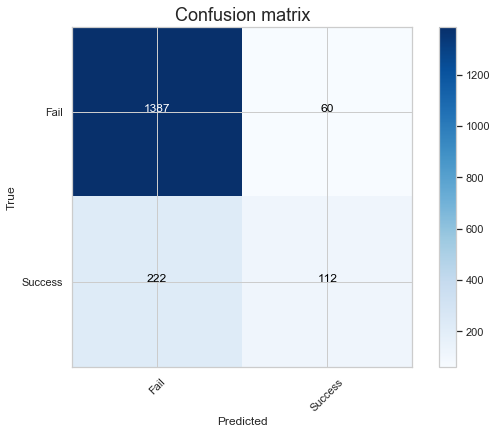

In [205]:
#m[2][4]

def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontdict={'fontsize': 18})
    sns.set_style( 'whitegrid',{'axes.grid' : False})
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, labels = classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")
    plt.ylim([1.5,-.5])
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.grid('off')
    plt.show()
    
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (8,6))
plot_confusion_matrix(cm, classes = ['Fail', 'Success'])


Normalized confusion matrix
[[0.9585349  0.0414651 ]
 [0.66467066 0.33532934]]


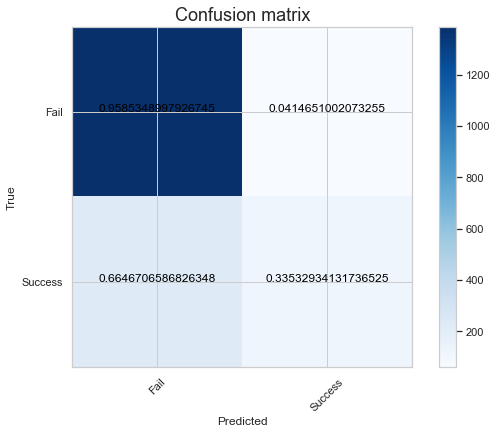

In [204]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (8,6))
plot_confusion_matrix(cm, classes = ['Fail', 'Success'], normalize = True)

Normalized confusion matrix
[[0.99101589 0.00898411]
 [0.8742515  0.1257485 ]]


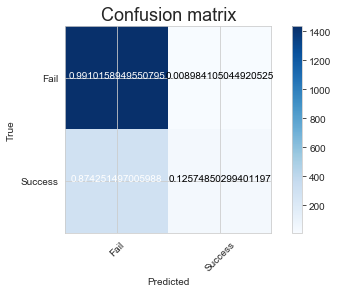

In [127]:
plot_confusion_matrix(cm,normalize = True, classes = ['Fail', 'Success'])

In [104]:
from sklearn.model_selection import RepeatedStratifiedKFold
# define models and parameters
model = RidgeClassifier()
alpha = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
# define grid search
grid = {'model__alpha':alpha}
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=pipe, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

[Pipeline] ..... (step 1 of 3) Processing preprocessor, total=296.0min
[Pipeline] .............. (step 2 of 3) Processing bal2, total=   1.3s
[Pipeline] ............. (step 3 of 3) Processing model, total=  10.3s
Best: 0.816363 using {'model__alpha': 0.9}
0.810367 (0.017409) with: {'model__alpha': 0.1}
0.811474 (0.017883) with: {'model__alpha': 0.2}
0.812027 (0.018071) with: {'model__alpha': 0.3}
0.812766 (0.017846) with: {'model__alpha': 0.4}
0.813688 (0.017870) with: {'model__alpha': 0.5}
0.814425 (0.018641) with: {'model__alpha': 0.6}
0.814335 (0.018202) with: {'model__alpha': 0.7}
0.815533 (0.018897) with: {'model__alpha': 0.8}
0.816363 (0.018171) with: {'model__alpha': 0.9}
0.816179 (0.018318) with: {'model__alpha': 1.0}


{'mean_fit_time': array([  89.29167231,   76.63596298,   72.30785348,   66.62470171,
          65.51719398,   63.3219614 ,   68.34306556,   67.94400611,
          72.54024591, 1147.64549252]),
 'std_fit_time': array([6.64264950e+00, 3.94361421e+00, 3.57428012e+00, 2.51164167e+00,
        2.14901634e+00, 2.55033018e+00, 8.52220742e+00, 2.51004073e+00,
        3.39069149e+00, 3.23683890e+03]),
 'mean_score_time': array([5.83218077, 5.60043542, 5.60391103, 5.31376548, 5.35496079,
        5.34178651, 5.69675825, 5.98505461, 6.2658687 , 5.75945344]),
 'std_score_time': array([0.6912041 , 0.54745043, 0.57481246, 0.43545885, 0.58029953,
        0.59411553, 0.73008918, 0.66579419, 0.59845144, 0.72189419]),
 'param_model__alpha': masked_array(data=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'params': [{'model__alpha': 0.1},
 

In [23]:
grid_search.scoring

<bound method BaseEstimator.get_params of GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['minimum_age',
                                                                          'maximum_age',
                                                                          'enrollment',
                                                                          'Num '
                                        

In [91]:
y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.89      0.91      0.90      1447
        True       0.56      0.51      0.53       334

    accuracy                           0.83      1781
   macro avg       0.73      0.71      0.72      1781
weighted avg       0.83      0.83      0.83      1781



In [ ]:
grid_search

In [367]:
pipe.fit(X_train, y_train)

C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['minimum_age', 'maximum_age',
                                                   'enrollment',
                                                   'Num of citations']),
                                                 ('pmid_tfidf',
                                                  Pipeline(steps=[('vectorizer',
                                                                   TfidfVectorizer())]),
                                                  'PMID_tokens'),
                                                

In [370]:
pipe.score(X_test, y_test)

0.8416619876473891

In [371]:
y_pred_tf = pipe.predict(X_test)
print(classification_report(y_pred_tf, y_test))

              precision    recall  f1-score   support

       False       0.97      0.86      0.91      1629
        True       0.31      0.67      0.42       152

    accuracy                           0.84      1781
   macro avg       0.64      0.76      0.66      1781
weighted avg       0.91      0.84      0.87      1781



In [305]:
pipe.fit(X_train, y_train)
#X_train.info

C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['minimum_age', 'maximum_age',
                                                   'enrollment',
                                                   'Num of citations']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
      

In [129]:
import pickle

def read_corpus_text(pdfs):
    for pdf in pdfs:
        print(pdf)
        raw = parser.from_file(pdf)
        num = re.findall(r'\d+', pdf)
        num = ''.join(num)
        #tokens = get_tokens(str(raw['content']))
        tokens = word_tokenize(str(raw['content']))
        with open('./tokenss/'+num+'.txt', 'wb') as file:
            pickle.dump(tokens, file)
    
    
def prepare_corpus():
    text = []
    for dir in os.listdir('./tokenss/'):
        with open('./tokenss/'+ dir, 'rb') as file:
            tokens = pickle.load(file)
        text.append(tokens)
            #yield gensim.corpora.Dictionary(tokens, dir)
    #for n, line in enumerate(brief_summary):
     #   yield gensim.models.doc2vec.TaggedDocument(line,brief_summary_index[n])
    return text

In [49]:
def isin(str_of_pmids):
    list_of_pmids = str_of_pmids.split(' ')
    tokens = []
    for pmid in list_of_pmids:
        if pmid in tokens_list:
            with open('./tokenss/'+pmid+'.txt', 'rb') as file:
                tokens.append(pickle.load(file)
                              
    tokens = [ ', '.join(token) for token in tokens]
    return ' '.join(tokens)
    

In [159]:
from sklearn.model_selection import RandomizedSearchCV
#from numpy import 
#model
MOD = RandomForestClassifier() 
#Implemente RandomSearchCV
m_params = { 
            "RF": {
                    "n_estimators" : np.linspace(2, 20, 10, dtype = "int"),  
                    "max_depth": [5, 20, 30, None], 
                    "min_samples_split": np.linspace(2, 50, 10, dtype = "int"),  
                    "max_features": ["sqrt", "log2",10, 20, None],
                    "oob_score": [True],
                    "bootstrap": [True]
                    },
            }
scoreFunction = {"recall": "recall", "precision": "precision"}
random_search = RandomizedSearchCV(MOD,
                               param_distributions = m_params['RF'], 
                                       n_iter = 10,
                                       n_jobs=-1,
                                       scoring = scoreFunction,               
                                       refit = "recall",
                                       return_train_score = True,
                                       random_state = 42,
                                       cv = 5,
                                        verbose = 1) 

    #trains and optimizes the model
random_search.fit(X_train_transformed, y_train)

    #recover the best model
MOD = random_search.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 14.1min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 18.9min finished
C:\Users\Public\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Public\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:545: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


In [575]:
log = LogisticRegression(solver =  'newton-cg', C = 10)
log.fit(X_train_resampled, y_train_resampled)

y_pred = log.predict(X_test_transformed)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.87      0.91      0.89      1398
        True       0.61      0.49      0.54       383

    accuracy                           0.82      1781
   macro avg       0.74      0.70      0.72      1781
weighted avg       0.81      0.82      0.82      1781



In [640]:
log = LogisticRegression(solver = 'liblinear', penalty = 'l2', C= 1)
log.fit(X_train_resampled, y_train_resampled)

y_pred = log.predict(X_test_transformed)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.85      0.95      0.90      1398
        True       0.71      0.40      0.51       383

    accuracy                           0.84      1781
   macro avg       0.78      0.68      0.71      1781
weighted avg       0.82      0.84      0.82      1781



## Conclusion

After cleaning the data and several iterations of different machine learning models, we achieved an accuracy of around 84%, with a 70% precision rate. With more data and institutional access to PMIDs we can evaluate the validity of this precision rate. Given a success rate of around 15%, we can say this prediction model returns significant results. Howver I would caution the use of these models with unseen interventions.

We focused on achieving a higher precision rate to avoid a higher false positive rate. In this scenario, we would like to decrease the amount of false positive predictions because a high amount of false positive predictions would give us a false sense of an accurate model. A false negative would not bear the same consequence as a false positive. A false positive can lead to a clinical trial that is truly unsuccessful thereby wasting millions of dollars and time that can be on a clinical trial that would actually succeed.

## Recommendations

1. This dataset is small. In order to gain more confidence in the model, institutional access to PMIDs is required.

2. After an analysis with more data we can deploy this model with a simple GUI for business partners interested in performing analysis prior to starting a clinical trial

3. Be wary of unseen interventions as the results may be unpredictable.

